## CA2 AIML Time-Series
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
### Background Infomation
In recent years, there has been a growing interest in understanding energy consumption patterns and forecasting future energy usage. Time series analysis has become a powerful tool in this regard, allowing researchers and policymakers to model and predict gas consumption, electricity consumption, and water consumption. These predictions are crucial for planning and managing energy resources efficiently and sustainably.
### Problem Statement
>Our objective is to use the Energy Consumption Dataset to train time series models and forecast the gas consumption, electricity consumption and water consumption in the future.

In [2]:
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from warnings import filterwarnings 

# Utility
from tqdm import tqdm # Track progress of a loop
import warnings # Ignore warnings
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
from IPython.display import display, HTML, Markdown
from statsmodels.tsa.stattools import kpss

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load Dataset

In [3]:
df_raw = pd.read_csv('./datasets/Energy Consumption Dataset.csv')
df_raw['DATE'] = pd.to_datetime(df_raw['DATE'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
df_raw

DATE  Gas Consumption (tons)  Electricity Consumption (MWh)  \
0   1990-01-01                    18.0                          725.1   
1   1990-02-01                    15.8                          706.7   
2   1990-03-01                    17.3                          624.5   
3   1990-04-01                    18.9                          574.7   
4   1990-05-01                    22.0                          553.2   
..         ...                     ...                            ...   
392 2022-09-01                    27.7                          986.2   
393 2022-10-01                    31.8                          936.1   
394 2022-11-01                    31.0                          973.4   
395 2022-12-01                    32.4                         1147.2   
396 2023-01-01                    31.3                         1294.0   

     Water Consumption (tons)  
0                       548.8  
1                       640.7  
2                       511.1  
3                       515.3  
4                       488.4  
..                        ...  
392                     513.3  
393                     373.1  
394                     343.9  
395                     348.3  
396                     260.2  

[397 rows x 4 columns]

## Datetime Index
__Why do we need to set the Date as the index?__
- By setting a datetime index, we convert the time series data into a time-aware data structure, with a time-aware data structure we unlock the ability to do time-based analysis, visualization, modeling and forecasting.

In [4]:
df = df_raw.copy()
df.index = df['DATE'] 
df.drop(columns= 'DATE', inplace = True) 
df

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   
...                            ...                            ...   
2022-09-01                    27.7                          986.2   
2022-10-01                    31.8                          936.1   
2022-11-01                    31.0                          973.4   
2022-12-01                    32.4                         1147.2   
2023-01-01                    31.3                         1294.0   

            Water Consumption (tons)  
DATE                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4  
...                              ...  
2022-09-01                     513.3  
2022-10-01                     373.1  
2022-11-01                     343.9  
2022-12-01                     348.3  
2023-01-01                     260.2  

[397 rows x 3 columns]

# Data Exploration
To prevent any changes from happening to our original dataset, we make a copy of it

In [5]:
df_eda = df.copy()

### Descriptive Statistics

In [6]:
df_eda.shape

(397, 3)

In [7]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1990-01-01 to 2023-01-01
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Gas Consumption (tons)         397 non-null    float64
 1   Electricity Consumption (MWh)  397 non-null    float64
 2   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3)
memory usage: 12.4 KB


In [8]:
df_eda.describe(include="all").T

count        mean         std    min    25%  \
Gas Consumption (tons)         397.0   23.785139    4.903452   11.6   20.2   
Electricity Consumption (MWh)  397.0  888.472544  153.877594  553.2  771.1   
Water Consumption (tons)       397.0  484.953652  133.908863   44.4  384.4   

                                 50%     75%     max  
Gas Consumption (tons)          23.5    27.9    46.0  
Electricity Consumption (MWh)  897.8  1005.2  1294.0  
Water Consumption (tons)       487.4   580.2   811.0

### Invalid Data
Invalid data in this case refers to data that does not make sense, such as data that has less than or equals to 0 for any of the features in the dataset

In [9]:
print(str(len(df_eda[(df_eda <= 0.00).any(axis=1)])) + " rows of invalid data found")

0 rows of invalid data found


### Missing Values

In [10]:
df_eda.isna().sum()

Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

# Data Visualization

### Distribution of Features

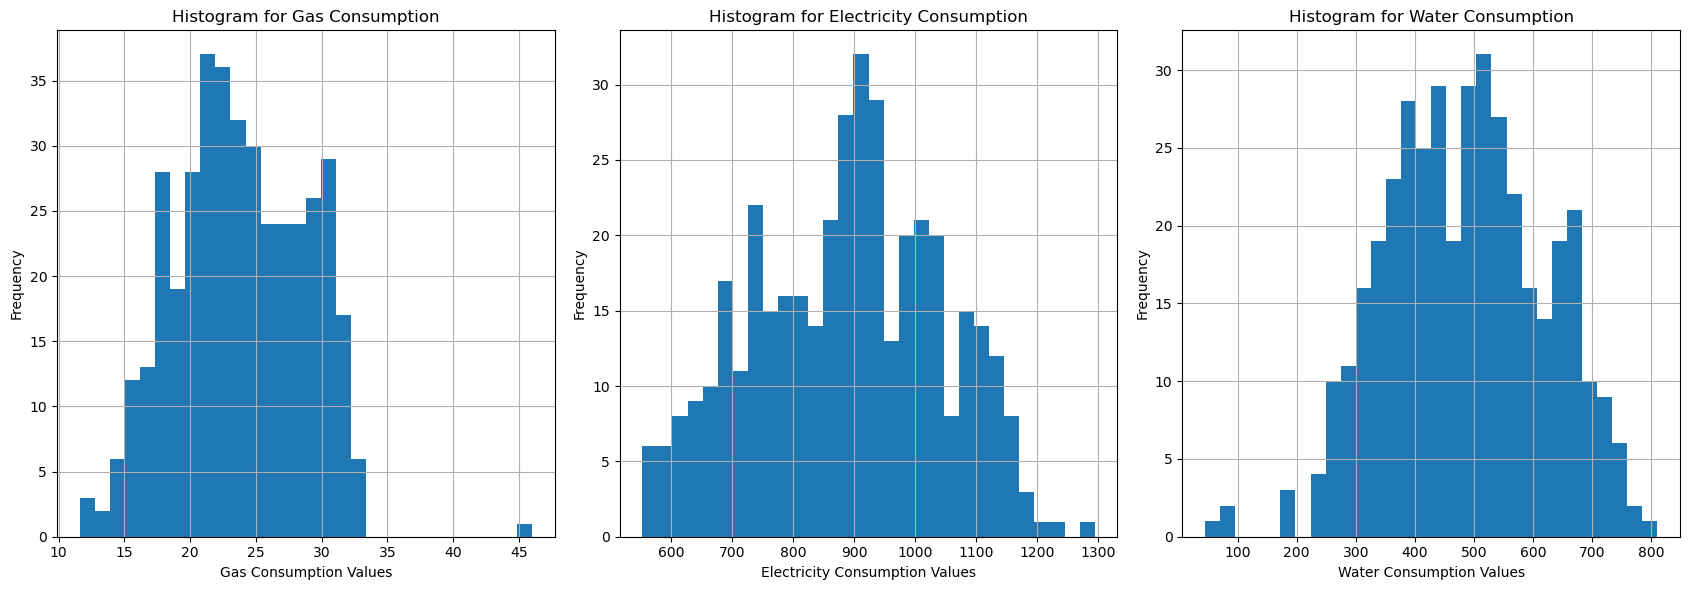

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))
df['Gas Consumption (tons)'].hist(ax=axes[0], bins=30)
axes[0].set_title('Histogram for Gas Consumption')
axes[0].set_xlabel('Gas Consumption Values')
axes[0].set_ylabel('Frequency')

df['Electricity Consumption (MWh)'].hist(ax=axes[1], bins=30)
axes[1].set_title('Histogram for Electricity Consumption')
axes[1].set_xlabel('Electricity Consumption Values')
axes[1].set_ylabel('Frequency')

df['Water Consumption (tons)'].hist(ax=axes[2], bins=30)
axes[2].set_title('Histogram for Water Consumption')
axes[2].set_xlabel('Water Consumption Values')
axes[2].set_ylabel('Frequency')

plt.tight_layout() 
plt.show()

Observations
- All of the features in our dataset has a relativly normal distribution
    - apart from Gas consumption where a outliers majorly affects the skewness of the dataset

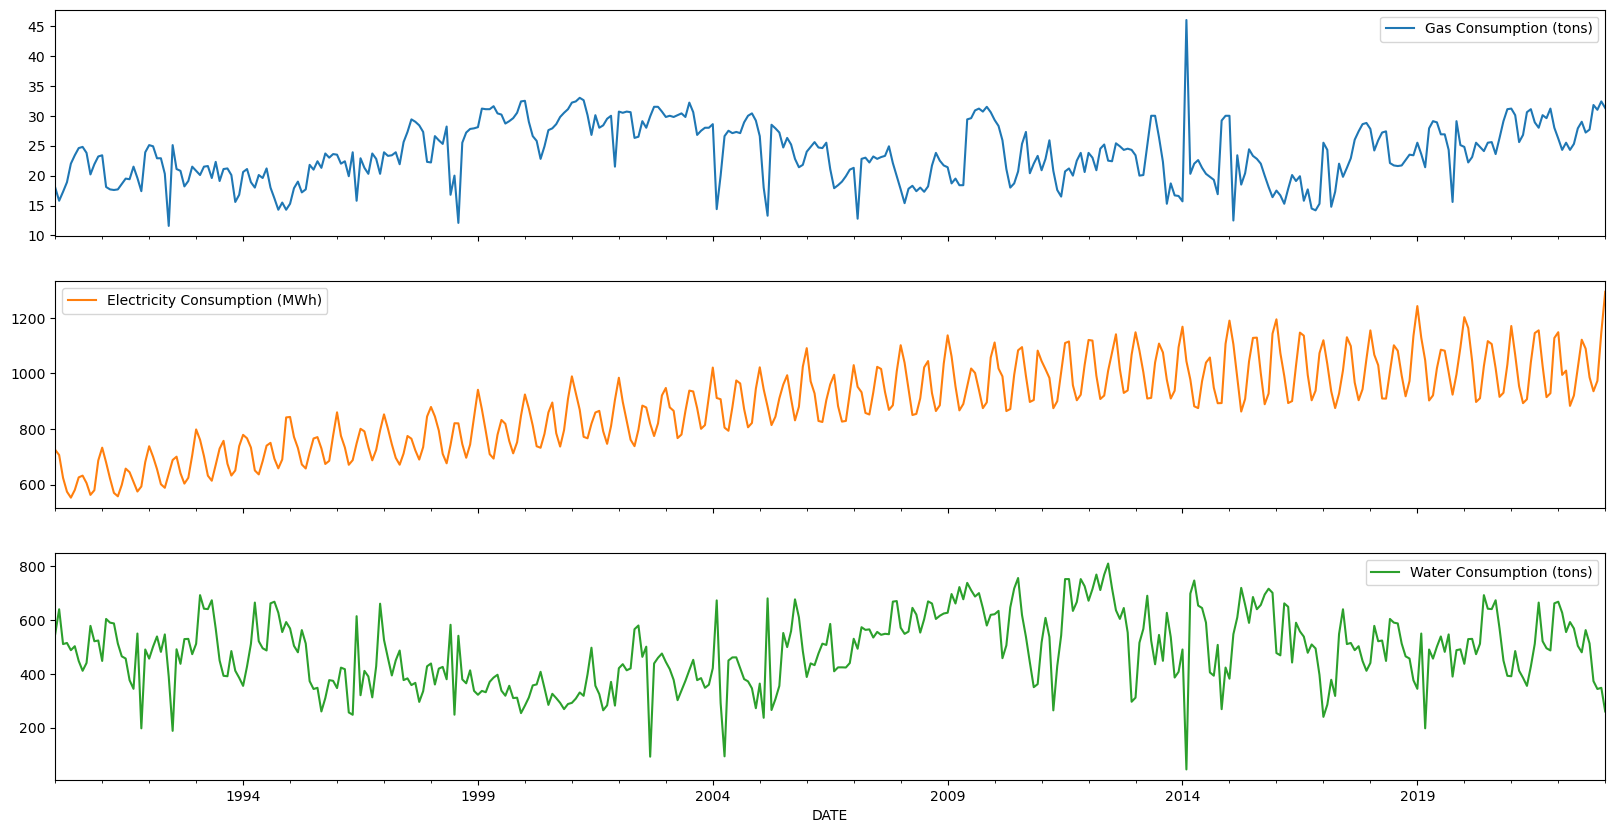

In [12]:
df.plot(subplots=True, figsize=(20, 10))
plt.show()

__Observations__
- There is a huge spike in the Gas consumption time series and that maybe an anomaly of our dataset. Such spikes may be caused by various factors, such as errors in data recording, meter malfunctions, extreme weather conditions and equipment failures
- We can see that there is strong seasonality in the Electricity consumption time series, with a slight visble increase in trend 
- The absence of a clear trend or seasonality in the water consumption time series .This is weird and need to be researched further as water consumption is often considered a stable or relatively constant process, at least in the absence of significant external factors.

# EDA
In order to gain deeper insights and better understand the underlying patterns of the time series problem, it is essential to conduct various tests to decompose the data.

These tests are:
- Stationary Test
- Autocorrelation Analysis
- Granger Causality Test
- Test for Cointegration
- STL Decomposition
- Test for Causation
- Anomaly Detection

## Stationary Test
We are going to test for Stationarity using `Augmented Dickey Fuller(ADF)` Test and `Kwiatkowski–Phillips–Schmidt–Shin(KPSS)` test. We want to test for stationarity is becuase a stationary time series is one where the statistical properties remain constant over time, making it easier to model and forecast accurately.[[1]](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

For a time series to be stationary it needs to fufil a few critiria[[2]](https://towardsdatascience.com/what-is-stationarity-in-time-series-and-why-should-you-care-f3b45082356b):
- __Constant Mean__: 
    - The mean of the time series remains constant over time. In other words, the data points do not show any systematic upward or downward trend.
- __Constant Variance__: 
    - The variance of the time series remains constant over time. The data points exhibit consistent spread or dispersion around the mean.
- __Constant Covariance__: 
    - The covariance between data points separated by the same time interval remains constant over time. This condition is also known as "covariance stationarity."


### Why do we need to test for stationarity in our Time series Analysis?
It is due to many reasons, one is that the ARIMA (Auto-Regressive Integrated Moving Average) model will make the assumption that the data is stationary.The model would not be able to properly forecast if the data is non-stationary[[3]](https://www.tutorialspoint.com/why-do-time-series-have-to-be-stationary-before-analysis#:~:text=The%20model%20will%20not%20be,series%20being%20stationary%20before%20analysis.). Another is easier analysis, as stationary time series has their statistical propeties remain constand over time, this simplifies the identification of patterns, trends and seasonality, making it easier to understand and interpret the underlying behavior of the data.


### Augmented Dickey Fuller Test
This test is used to test for the presence of a unit root in a time series. A unit root in a time series means that the time series is non-stationary and exhibits a stochastic trends.

We will be using ADF at significant Value p = 0.05 with:
- $$H_0 : \text{Time-Series is Non-Stationary}$$
- $$H_1 : \text{Time-Series is Stationary} $$


In [13]:
adf = []
for var in df.columns:
    adf.append(adfuller(df[var])[1])

adfResults = pd.DataFrame(dict(Variable = df.columns,P_Value = adf, Stationary = [p<0.05 for p in adf]))
def highlight_third_row(row):
    if row.name == 2:  # Row index 2 corresponds to the third row (0-indexed)
        return ['background-color: red'] * len(row)
    else:
        return [''] * len(row)

# Apply the style function to the DataFrame
styled_results_df = adfResults.style.apply(highlight_third_row, axis=1)

# p<0.05 = reject null hypothesis = stationary
# Display the styled DataFrame
display(styled_results_df)
print("Number of non-stationary variables: " + str(sum([p<0.05 for p in adf])))

Number of non-stationary variables: 2


### Kwiatkowski–Phillips–Schmidt–Shin Test
This test is used to determine the stationarity of a series around a deterministic trend. A deterministic trend is a trend that has a clear and systematic pattern over time. It is a predictable and fixed pattern that can be modeled and removed from the time series data[[4]](https://stats.stackexchange.com/questions/241144/explain-what-is-meant-by-a-deterministic-and-stochastic-trend-in-relation-to-the).In the context of the KPSS test, a series with a deterministic trend is considered to be trend-stationary. Trend-stationary processes are mean-reverting after a shock or disturbance. This means that the series will eventually return to the trend line after being affected by a temporary shock. 

We will be using KPSS at Significant Value p = 0.05 with:

- $$H_0 : \text{Time-Series is Stationary} $$
- $$H_1 : \text{Time-Series is Non-Stationary}$$


In [14]:
filterwarnings('ignore')

kpss_vals = []
for var in df.columns:
    kpss_result = kpss(df[var])
    kpss_vals.append(kpss_result[1])

kpssResults = pd.DataFrame({'Variable': df.columns,'P_Value_KPSS': kpss_vals,'Stationary': [p > 0.05 for p in kpss_vals]})
def highlight_third_row(row):
    if row.name == 2:  # Row index 2 corresponds to the third row (0-indexed)
        return ['background-color: red'] * len(row)
    else:
        return [''] * len(row)

# Apply the style function to the DataFrame
styled_results_df = kpssResults.style.apply(highlight_third_row, axis=1)

# p<0.05 = reject null hypothesis = non-stationary
# Display the styled DataFrame
display(styled_results_df)
print("Number of stationary variables (based on KPSS test):", sum([p < 0.05 for p in kpss_vals]))

Number of stationary variables (based on KPSS test): 2


__Observations:__
- We do not reject the null hyposthesis for `Electricity consumption` in the ADF test, suggesting that the time series for Electricity consumption is __non-stationary__. The KPSS test also supports this by rejecting the null hypothesis, which indicates that the time series is __non-stationary__.
- We reject the null hypothesis for `Gas consumption` in the ADF test, suggesting that the time series for gas consumption is __stationary__. The KPSS test also supports this by not rejecting the null hyposthesis, which indicated that the time series in __stationary__.
- However when we see the results for the time series for `Water consumption`, the results are `contridictory`. Both ADF and KPSS test  get rejected as the pvalue is less than 0.05.

### Why do we get contradictory results from Water Consumption?
When both tests fail to reject their respective null hypotheses, it implies that the Water consumption time series exhibits characteristics of both trend-stationarity and difference-stationarity simultaneously. We will be using a Variance Ratio test to quantify how important the unit root is.

#### Variance Ratio Tests
The outcomes of a variance ratio test can be divided into roughly 5 different groups.

- __Bigger than 1__ After the shock the value of the variable explodes even more in the direction of the shock.
- __(Close to) 1__ You get this value in the "classical case of a unit root"
- __Between 0 and 1__ After the shock the value approaches a level between the value before the shock and the value after the shock.
- __(Close to) 0__ The series is (close to) stationary
- __Negative__ After the shock the value goes into the opposite direction, i.e. if the value before the shock is 20 and the value after the shock is 10 over the long haul the variable will take on values greater than 20.

[Source](https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916)

In [15]:
from statsmodels.stats.stattools import jarque_bera

def compute_variance_ratio(returns, k):
    variances = [np.var(returns[i:i+k]) for i in range(0, len(returns) - k + 1)]
    ratio = np.mean(variances[k:]) / np.mean(variances[:k])
    return ratio

def variance_ratio_test(returns, k):
    # Perform the variance ratio test
    ratio = compute_variance_ratio(returns, k)
    n = len(returns)
    p_value = 1.0 - (6.0 / (n - 2.0 + 5.0 * ratio**2))
    return p_value

log_returns = np.diff(df['Water Consumption (tons)'])


for k in np.arange(2, 15):
    p_value = variance_ratio_test(log_returns, k)
    print('k = {:d}, p-value = {:.4f}'.format(k, p_value))

k = 2, p-value = 0.9850
k = 3, p-value = 0.9862
k = 4, p-value = 0.9878
k = 5, p-value = 0.9878
k = 6, p-value = 0.9870
k = 7, p-value = 0.9864
k = 8, p-value = 0.9860
k = 9, p-value = 0.9858
k = 10, p-value = 0.9859
k = 11, p-value = 0.9859
k = 12, p-value = 0.9853
k = 13, p-value = 0.9851
k = 14, p-value = 0.9850


Observations:
- We can see that for all values of k, the p value is close to 1, resulting in a "classical case of a unit root". 

We can conclude that Water consumption Time series __has a unit root__ and is __non-stationary__

## Autocorrelation Analysis
Autocorrelation is intended to measure the relationship between a variable's present value and any past values that you may have access to[[5]](https://www.influxdata.com/blog/autocorrelation-in-time-series-data/).The autocorrelation function (ACF) is used to compute autocorrelation, and it quantifies how a time series observation at a specific time step is related to its observations at previous time steps.

The main use of autocorrelation analysis is to use ACF and PACF to identify the appropriate autoregressive(AR) and moving average(MA) model order.

### Difference between PACF and ACF
Autocorrelation is a calculation of the correlation of the time series observations with values of the same series, but at previous times.While Partial Autocorrelation,summarizes the relationship between an observation in a time series with observations at previous time steps, but with the relationships of intervening observations removed.[[6]](https://emel333.medium.com/interpreting-autocorrelation-partial-autocorrelation-plots-for-time-series-analysis-23f87b102c64). In simpler terms, ACF looks at the `overall relationship`, while PACF looks at the `direct relationship between two points` at a specific time interval. 

---

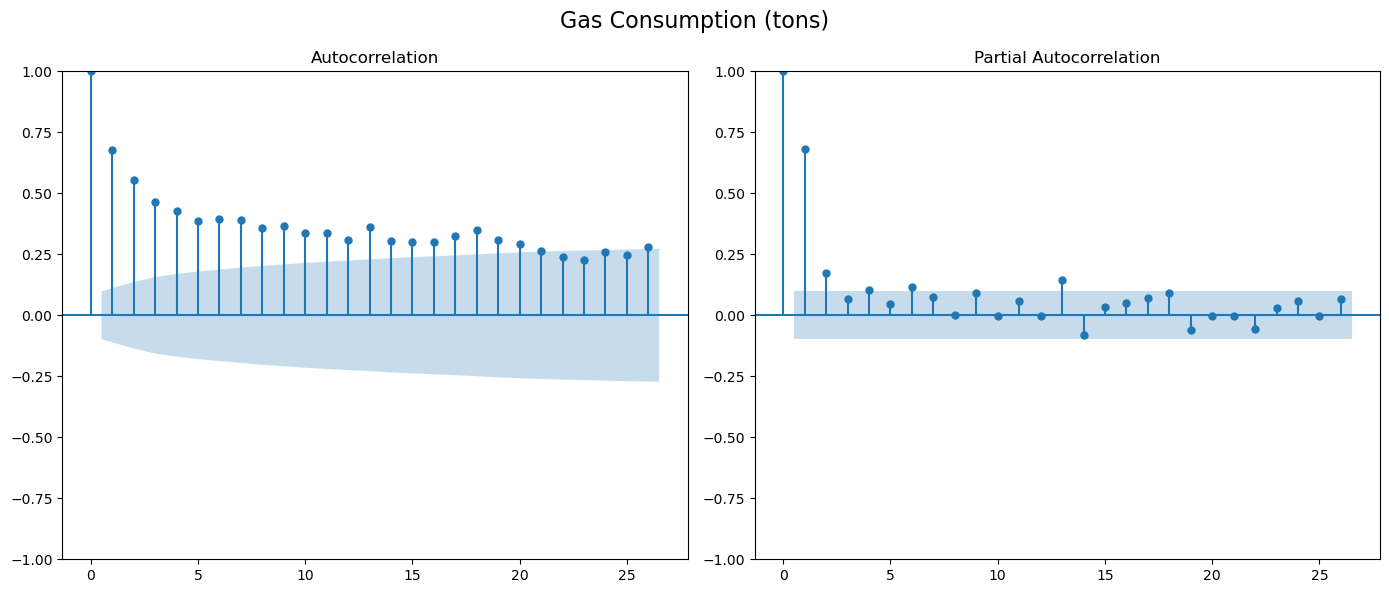

---

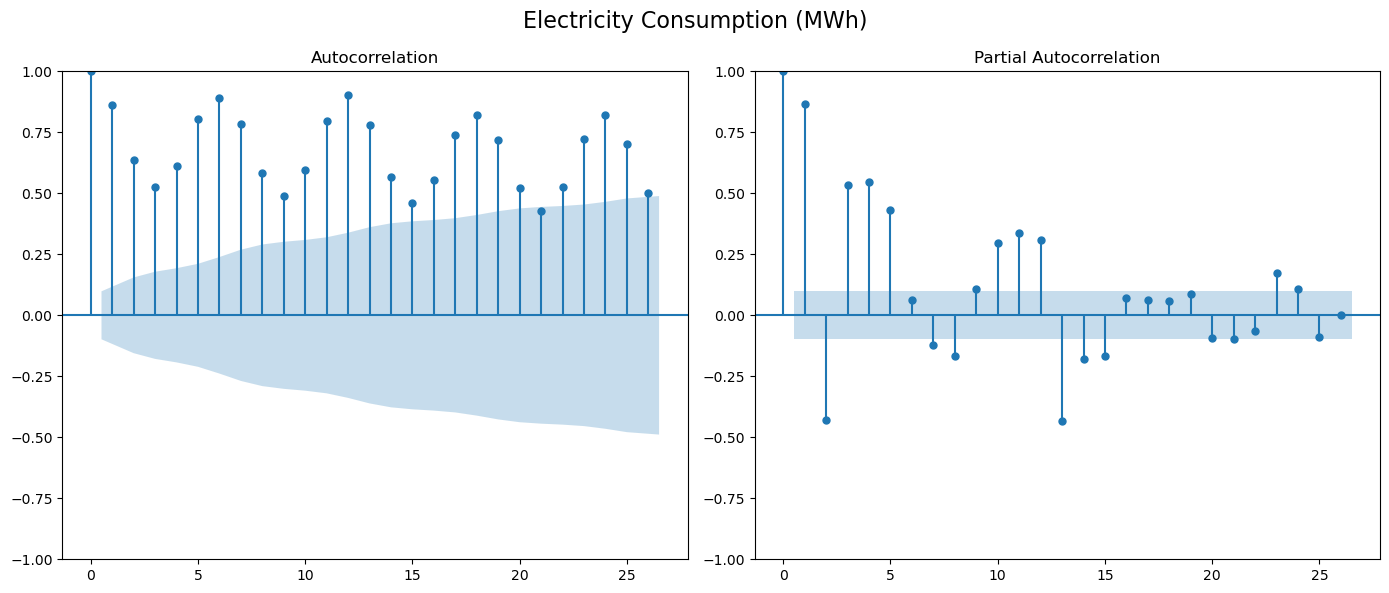

---

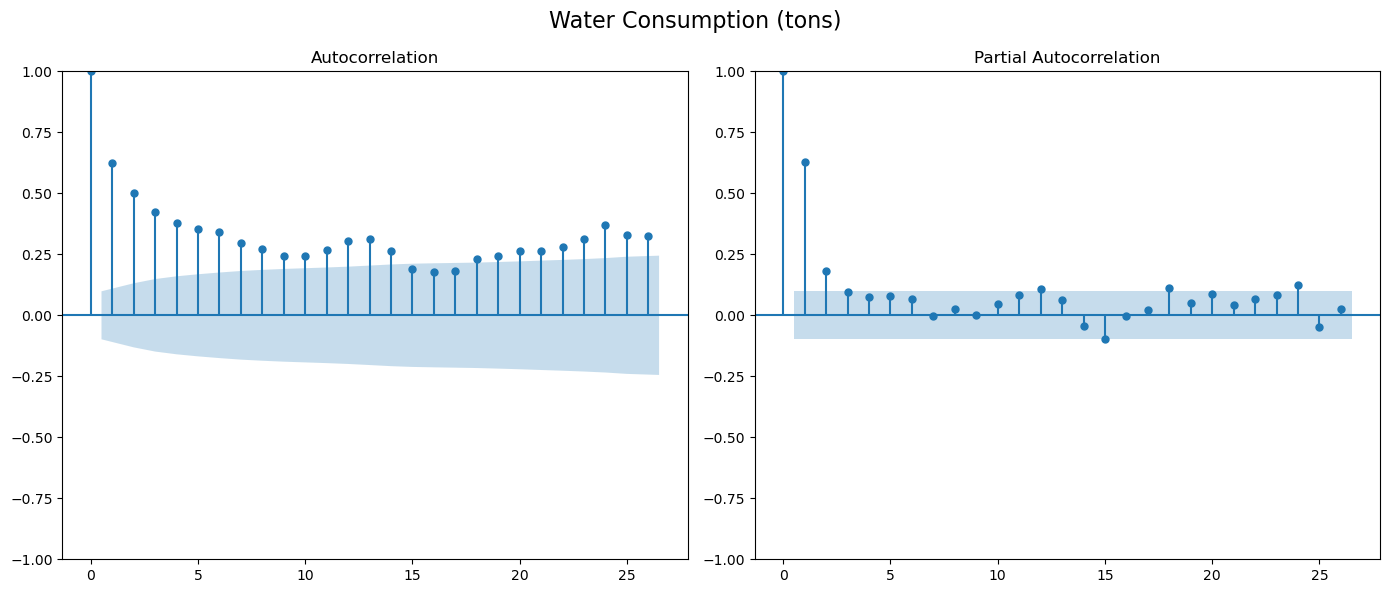

---

In [16]:
display(Markdown("---"))
for i in df.columns:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6),tight_layout=True)
    plot_acf(df[i], ax=ax[0])
    plot_pacf(df[i], ax=ax[1])
    fig.suptitle(i, fontsize=16)
    plt.show()
    display(Markdown("---"))

__Observations:__
- We notice that at zero lag, the ACF is always at zero as that variable is 100% correlated with itself. The values inside of the blue bands are statistically insignificant.
- To choose the p value (autoregressive order), we will first look at the PACF plots. There is a significant lag spike at lag 1 for all the autocorrelation plot which makes p = 1 a prime candidate.
- To choose the q value (moving average order), we need to look at the ACF plot. Any points that are outside of the blue shaded region are potential candidates, which means that q = 1- 14, 18-27 are good candiates for q. q = 1 are better candiates as it has the highest autocorrelation among all the plots.

The values that we are using for to get the perfect number of AR and MA to train our models are:

- Gas Consumption (p,q) = (1,1)
- Electricity Consumption (p,q) = (1,1)
- Water Consumption (p,q) = (1,1)

## Test for Causation

We will be using the `Granger causality test`, which is a statistical method used in time series analysis to determine whether one time series can be used to predict another time series. 

The main idea behind the Granger causality test is to assess whether the past values of one time series (referred to as the "predictor" or "X") contain useful information for predicting the future values of another time series (referred to as the "response" or "Y").

Although we are testing the casuality of X to Y, it is not excatly testing the true cause and effect relationship between X and Y. That’s because, in many occasions, correlation does not necessarily imply causation. We only test if X (and lags of X) is helpful in explaining Y, and thereby help forecasting it. So we are not concerned about the true causal relationship between the variables. That’s why say “X Granger causes Y”. instead of just “X causes Y”.[[7]](https://www.machinelearningplus.com/time-series/granger-causality-test/)

This test will help us in deciding whether a Multivariate model is useful for this time series
- $$H_0 : \text{X does not Granger Cause Y} $$
- $$H_1 : \text{X does Granger Cause Y}$$


<Axes: >

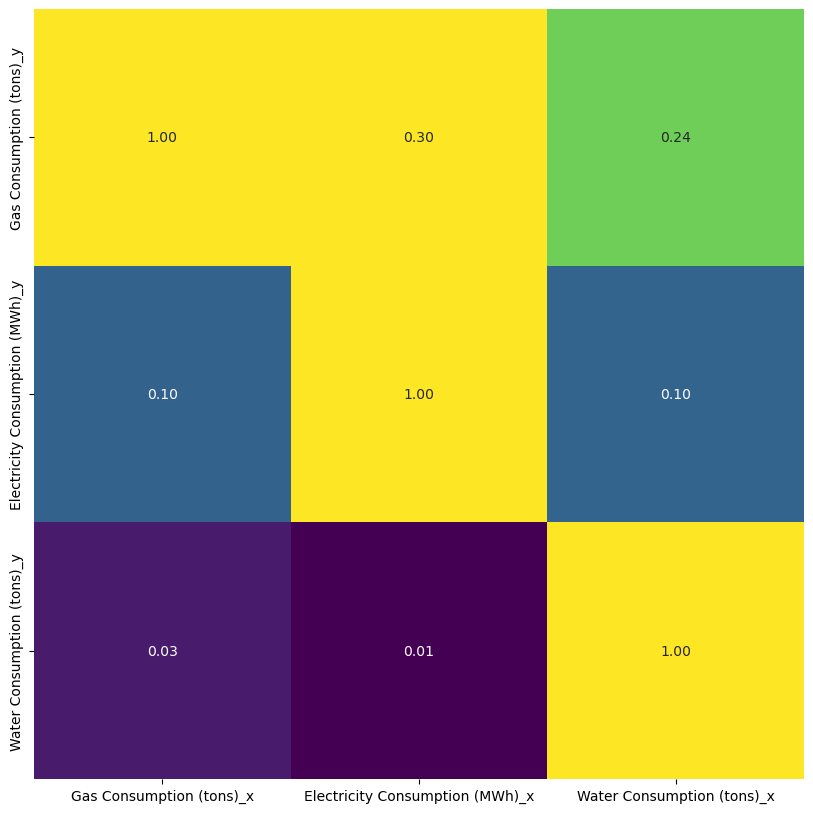

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=12, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(12)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

g_test = grangers_causation_matrix(df, variables = df.columns)     

# plot g_test heatmap
plt.figure(figsize=(10,10))
sns.heatmap(g_test, vmax=0.3, square=True, annot=True, fmt='.2f', cbar=False, cmap='viridis')

__Obseravtions:__
- When p-value < 0.05, we reject the null hypothesis and conclude that X will Granger cause Y
- From the heatmap we can conclude that
    - Gas Consumption Granger cause Water consumption
    - Electricity consumption Granger cause Water consumption

## Test for Cointegration
Cointergration is used to describe the long term relationship between 2 or more __non-stationary variables__[[8]](https://www.wallstreetmojo.com/cointegration/#:~:text=Cointegration%20is%20a%20statistical%20method,for%20two%20or%20more%20variables.).When variables are cointegrated, it means that they share a common stochastic trend, which is a shared underlying long-term movement or fluctuation observed in multiple time series data. In simpler terms, cointegration indicates that multiple time series move together over time, even though each series might have its own short-term fluctuations.

We will be using Johansen's cointegration test to test the cointergration of our 2 non-stationary time series, Water consumption and Electircity consumption.

- $$H_0 : \text{There is no Cointergration} $$
- $$H_1 : \text{There is some Cointergration}$$

### Cointergration vs correlation
Although both cointergration and correlation describe some underlying relationship between variables, these 2 properties are not synonymous. It is very possible for two time series to have weak/strong correlation but strong/weak cointegration[[9]](https://medium.com/analytics-vidhya/cointegration-for-time-series-analysis-1d0a758a20f1). 

__Correlation__
- focuses on the `short term relationships` and measures how the 2 variables move together in a linear manner

__Cointergration__
- examines `long term relationhips` and indentifies whether multiple time series have a shared stochastic trend, disregarding short term fluctions


In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
X = df['Electricity Consumption (MWh)']
Y = df['Water Consumption (tons)']

def johansen_cointegration_test(data):
    result = coint_johansen(data, det_order=0, k_ar_diff=1)
    trace_statistic = result.lr1[0]  
    cv_90 = result.cvm[0, 1]        
    cv_95 = result.cvm[0, 2]         
    p_value = result.lr1[1]

    if p_value < 0.05:
        print('P-value = ',p_value,": which is < 0.05","\nReject the null hypothesis \n(H0): There is some cointegration.")
    else:
        print('P-value = ',p_value,": which is > 0.05","\nFail to reject the null hypothesis \n(H0): There is no cointegration.")


data = pd.concat([X, Y], axis=1)
johansen_cointegration_test(data)

P-value =  41.029348330582096 : which is > 0.05 
Fail to reject the null hypothesis 
(H0): There is no cointegration.


__Observations:__
- Water consumption and Electricity` does not have a significant cointergration`, suggesting they do not share a common stochastic trend

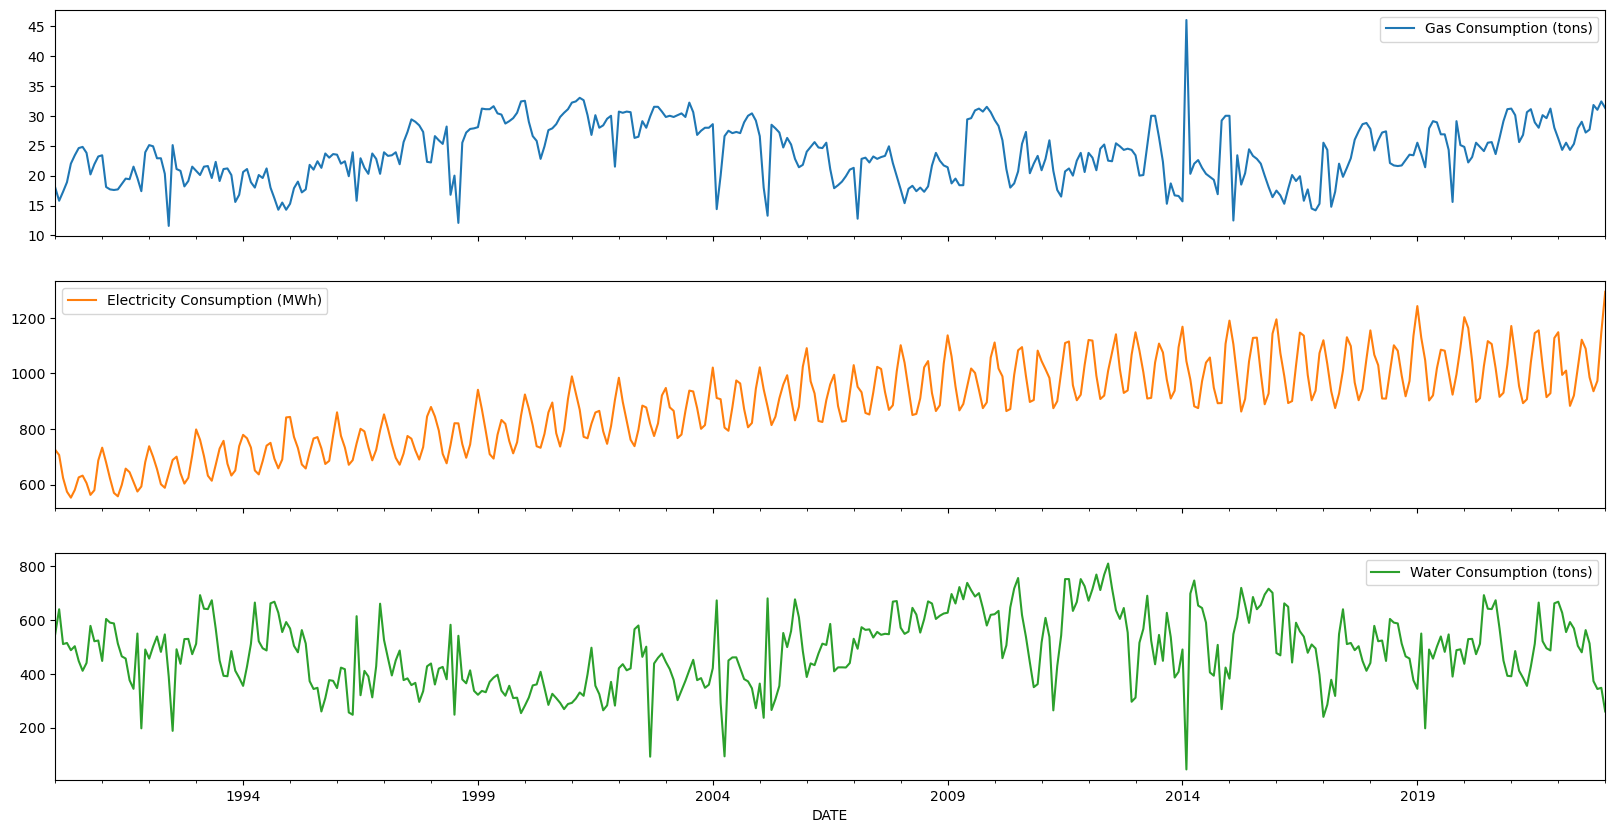

In [19]:
df.plot(subplots=True, figsize=(20, 10))
plt.show()

## STL (Seasonal-Trend decomposition using Loess)
STL is a widely used method to decompose time series data into its underlying components: seasonal, trend, and remainder. The purpose of this decomposition is to better visualize and understand the patterns, trends and seasonal variations present in the time series.

We have 2 ways of decomposing our time series, Multiplicative and Additive. So which should we choose?

__Multiplicative__ : ($y_t = S_t \times T_t \times R_t$)
- We should use it when the magnitude of seasonality changes over time [[10]](https://www.encora.com/insights/a-visual-guide-to-time-series-decomposition-analysis)
- Has an increasing or decreasing frequency and/or amplitude over time [[11]](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/).

__Additive__ : ($y_t = S_t + T_t + R_t$)
- The seasonal patterns have the same magnitude every year [[10]](https://www.encora.com/insights/a-visual-guide-to-time-series-decomposition-analysis)
- Has the same frequency (width of cycles) and amplitude (height of cycles) [[11]](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/).

We will be using a `additive mode` for this test as the variance does not change as the mean changes


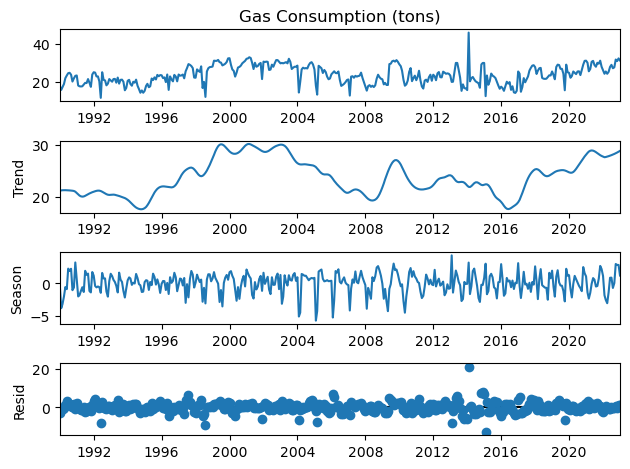

In [20]:
stlGas = STL(df['Gas Consumption (tons)'], period=12)
res = stlGas.fit()
fig = res.plot()

Observations:
- The  trend component of gas consumption shows a __fluctuating pattern without a clear linear trend__, this may indicate that this TS is infuenced by outiside factors that cause fluctations over time 
- Seasonality seems to be __inconsistent__, with it being strong around 2004 to 2011
    - Seasonality seems to be occuring annually
- An irregularity is observed in the residual component of gas consumption __around the year 2015__.

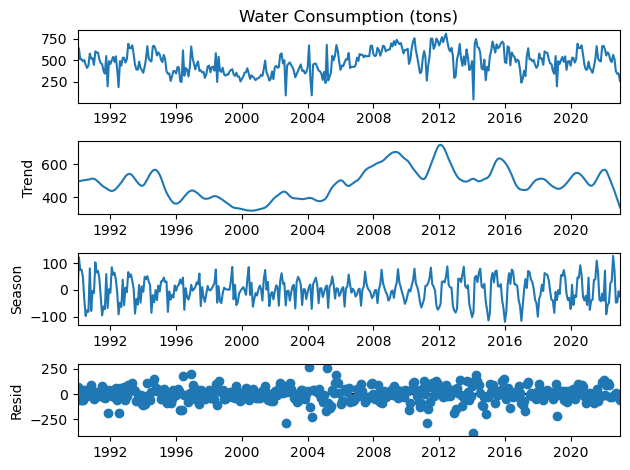

In [21]:
stlWater = STL(df['Water Consumption (tons)'], seasonal=13)
res = stlWater.fit()
fig = res.plot()

Observations:
- Similar to gas consumption, the  trend component of water consumption also exhibits a __fluctuating non-linear pattern__
    - it has a __downward decreasing non-linear__ trend at the start, at around 2005 it starts to increase
- The seasonal component of water consumption also seems to be __inconsistent overall__.
    - seasonality seems to be occuring __annually__
-  Irregularities are observed in the residual component of water consumption around the __year 2004.__

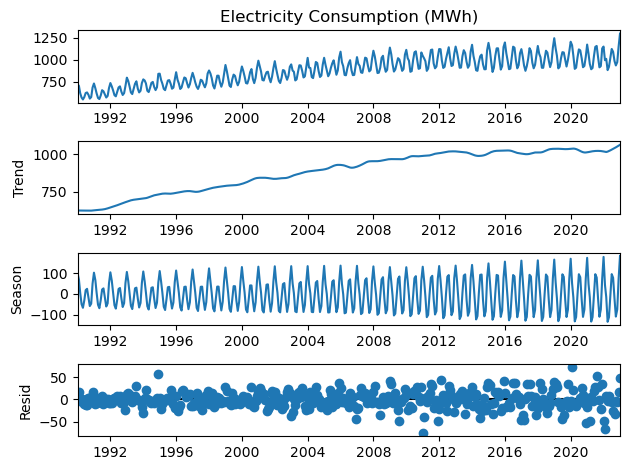

In [22]:
stlElectricity = STL(df['Electricity Consumption (MWh)'], seasonal=13)
res = stlElectricity.fit()
fig = res.plot()

Observations:
- The  trend component of electricity consumption indicates an __upward increasing linear trend__. This may indicate that ELectricity has been consistently rising over time.
- Electricity consumption  exhibits __consistent seasonality__
    - seasonality seems to be occuring __annually__
-  The residual component of electricity consumption shows an __increasing spread of variance after 2010.__

### Strength of trend and seasonality
How can we measure and compare the trend and seasonality of our previous results? We will be using Strength of Trend ($F_T$) and Strength of Seasonality ($F_S$). These values can help us understand the significance and magnitude of the trend and seasonality patterns present in the data.

__Strength of Trend ($F_T$):__
$$
F_T = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$
A higher $F_T$ value indicates a stronger trend, suggesting that the data has a more pronounced and consistent upward or downward movement over time. On the other hand, a lower $F_T$value indicates a weaker trend, implying that the data is more volatile or does not exhibit a consistent long-term pattern.

__Strength of Seasonality ($F_T$):__
$$
F_S = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})
$$
A higher $F_S$ value indicates a stronger seasonality, meaning that the data shows more consistent and pronounced seasonal variations over the defined seasonal period (e.g., yearly, quarterly, monthly). Conversely, a lower $F_S$value suggests weaker seasonality

[Source](https://otexts.com/fpp3/stlfeatures.html)

In [23]:
def calculate_trend_seasonality_strength(time_series):
    trend_strength , seasonality_strength = [],[]
    for i in time_series.columns:
        stl_result = STL(time_series[i], seasonal=13).fit()
        var_trend = stl_result.trend.var()
        var_seasonality = stl_result.seasonal.var()
        var_remainder = stl_result.resid.var()
    
        trend_strength.append(max(0,1-(var_remainder / (var_trend + var_remainder))))
        seasonality_strength.append(max(0,1-(var_remainder / (var_seasonality + var_remainder))))
    
    result_df = pd.DataFrame({
        'Columns': time_series.columns,
        'Trend Strength': trend_strength,
        'Seasonality Strength': seasonality_strength
    })
    
    return result_df

calculate_trend_seasonality_strength(df)

Columns  Trend Strength  Seasonality Strength
0         Gas Consumption (tons)        0.597336              0.128750
1  Electricity Consumption (MWh)        0.979534              0.937939
2       Water Consumption (tons)        0.580822              0.262786

Observations:
- ELectricity consumption has the `highest trend and seasonalty strength`, supported by the STL decomposition above
    - which indicates that the trend component (long-term direction) and the seasonal component (recurring patterns) are relatively dominant compared to the noise or remainder component in the data.
- Both Water and Gas consumption have rather `weak seasonalty strength`, and `moderate trend strength`
    - which indicates that the long-term trend has some influence on water and Gas consumption, but the recurring seasonal patterns are not as dominant as in the case of electricity consumption.

## Anomaly Detection
Anomaly detection  is the process of identifying data points or patterns that deviate significantly from the expected behavior or normal patterns of the time series.

We will be using Exponentially Weighted Moving Average for anomaly detection.It is advantages to us due to its ability to adaptively respond to recent changes in the data while maintaining memory of past observations, and is particularly useful for detecting anomalies in time series where there may be underlying trends or seasonality [[12]](https://www.mikulskibartosz.name/using-exponentially-weighted-moving-average-for-anomaly-detection/)

We will be using a window of 6, as our time series data is collected monthly and a larger window maybe suitable to capture long term trends. Data outside of 2 standard deviations from the mean will be considered as anomalies

### How does Anomly detection defer from outlier detection?
Anomaly detection and outlier detection are related concepts, but they are not entirely synonymous. Outliers refer to data points that are significantly different from the majority of the data and can be seen as extreme values in a dataset. On the other hand, anomalies represent unusual or unexpected patterns that may not necessarily be extreme values but deviate significantly from the expected behavior of the time series.

We can say that all __anomalies can be considered outliers__, but __not all outliers are neccessarily considered anomalies__[[13]](https://datascience.stackexchange.com/questions/24760/what-is-the-difference-between-outlier-detection-and-anomaly-detection).

Anomalies can manifest as point anomalies (individual data points that are anomalous), contextual anomalies (data points that are anomalous only in a specific context), or collective anomalies (groups of data points that exhibit anomalous behavior when considered together)[[14]](http://cucis.ece.northwestern.edu/projects/DMS/publications/AnomalyDetection.pdf).



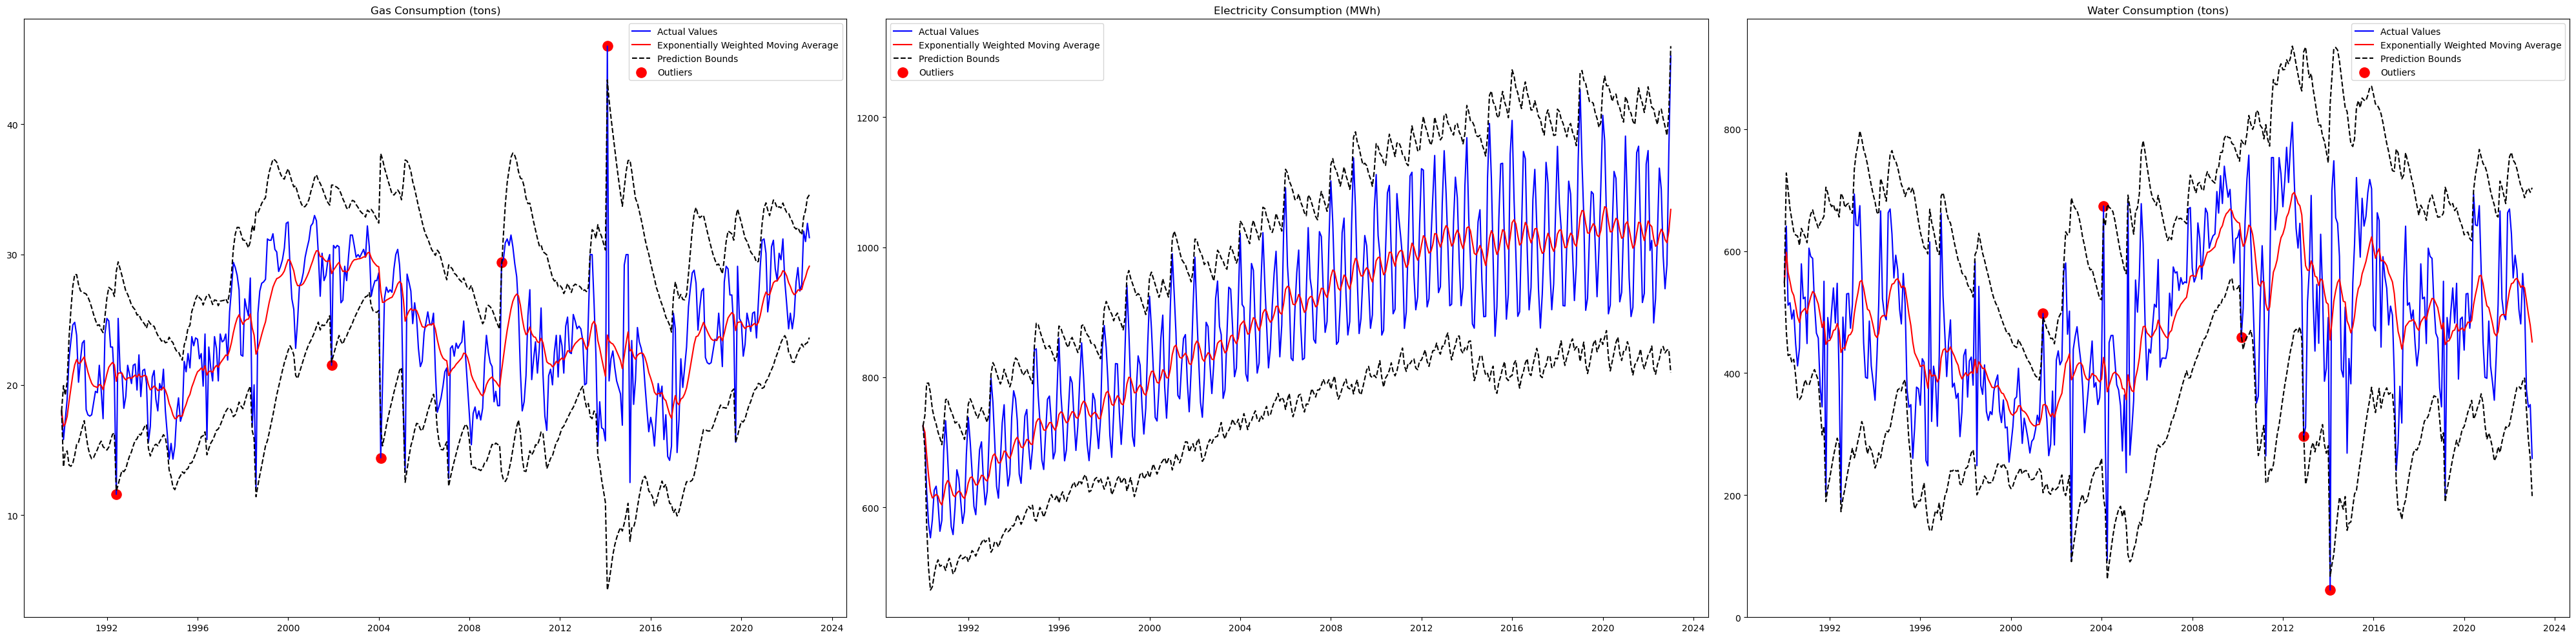

In [24]:
def outlier_detection(target=None,windows=6,name='My Plot',ax=plt):
    mean = target.ewm(windows).mean()
    std = target.ewm(windows).std()
    std[0] = 0 
    no_of_std=2
    is_outlier = (target > (mean + no_of_std*std)) | (target < (mean - no_of_std*std))
    
    ax.plot(target, c = 'b', label = 'Actual Values')
    ax.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
    ax.plot((mean + no_of_std*std), 'k--', label = 'Prediction Bounds')
    ax.plot((mean - no_of_std*std), 'k--')
    ax.set_title(name)
    ax.scatter(target[is_outlier].index, target[is_outlier], c = 'r', marker = 'o', s = 120, label = 'Outliers')
    ax.legend()
    return is_outlier

fig, ax = plt.subplots(1, 3, figsize=(40, 10), tight_layout=True)
ax = ax.flatten()
for col,name in enumerate(df.columns):
    outlier_detection(df[name],7,name,ax[col])

## Summary of Observations from EDA
__Stationarity:__
- Electricity and Water consumption are `non-stationary`
- Gas consumption is `stationary`

__Values for AR and MA for each time series:__
- Gas Consumption (p,q) = `(1,1)`
- Electricity Consumption (p,q) = `(1,1)`
- Water Consumption (p,q) = `(1,1)`

__Granger causality test:__
- Gas Consumption Granger cause Water consumption
- Electricity consumption Granger cause Water consumption

__Cointergration:__
- our 2 non-stationary variables, Electricity and water consumption `does not have` a significant cointergration.

Strength of trend and seasonalty:
- Electricity consumption has the highest trend and seasonalty strength
- Water and Gas consumption have  weak seasonalty strength, and moderate trend strength


# Model Selection
We will be using the models:
1. ARIMA
2. SARIMA
3. Holt-Winters Exponential Smoothing

We will be using the ARIMA model as a baseline to compare SARIMA and VARMAX

#### Difference between the models ARIMA and SARIMA
ARIMA(Auto-Regressive Integrated Moving Average) describes the relationship between the current value of a time series and its past values, incorporating auto-regressive(AR), integrated(I), and moving average(MA) components. On the other hand SARIMA extends ARIMA by considering `seasonal patterns` in the data. SARIMA includes additional seasonal parameters and is capable of forecasting data with recurring cycles. Specifically, SARIMA incorporates seasonal auto-regressive(SAR), integrated(I), and moving average(MA) terms.[[15]](https://www.longdom.org/open-access/a-comparative-study-of-arima-and-sarima-models-to-forecast-lockdowns-due-to-sarscov2-98209.html)[[16]](https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f)


We need to make sure that there are no NULL values in our dataset and remove all NA values.

In [25]:
df_new = df.copy().dropna()
df_new

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   
...                            ...                            ...   
2022-09-01                    27.7                          986.2   
2022-10-01                    31.8                          936.1   
2022-11-01                    31.0                          973.4   
2022-12-01                    32.4                         1147.2   
2023-01-01                    31.3                         1294.0   

            Water Consumption (tons)  
DATE                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4  
...                              ...  
2022-09-01                     513.3  
2022-10-01                     373.1  
2022-11-01                     343.9  
2022-12-01                     348.3  
2023-01-01                     260.2  

[397 rows x 3 columns]

### Train test split

In [26]:
train_size = int(len(df_new) * 0.8)
df_train, df_test = df_new[0:train_size], df_new[train_size:len(df_new)]
print(f"df_train.shape = {df_train.shape}, df_test.shape = {df_test.shape}")
display(df_train, df_test)

df_train.shape = (317, 3), df_test.shape = (80, 3)


Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   
...                            ...                            ...   
2016-01-01                    17.5                         1194.9   
2016-02-01                    16.7                         1073.8   
2016-03-01                    15.3                          991.0   
2016-04-01                    17.8                          893.6   
2016-05-01                    20.1                          900.7   

            Water Consumption (tons)  
DATE                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4  
...                              ...  
2016-01-01                     477.8  
2016-02-01                     469.2  
2016-03-01                     662.7  
2016-04-01                     649.9  
2016-05-01                     442.5  

[317 rows x 3 columns]

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
2016-06-01                    19.1                         1028.2   
2016-07-01                    19.9                         1147.1   
2016-08-01                    15.8                         1136.0   
2016-09-01                    17.7                          994.7   
2016-10-01                    14.5                          903.6   
...                            ...                            ...   
2022-09-01                    27.7                          986.2   
2022-10-01                    31.8                          936.1   
2022-11-01                    31.0                          973.4   
2022-12-01                    32.4                         1147.2   
2023-01-01                    31.3                         1294.0   

            Water Consumption (tons)  
DATE                                  
2016-06-01                     590.7  
2016-07-01                     558.5  
2016-08-01                     538.8  
2016-09-01                     478.8  
2016-10-01                     509.7  
...                              ...  
2022-09-01                     513.3  
2022-10-01                     373.1  
2022-11-01                     343.9  
2022-12-01                     348.3  
2023-01-01                     260.2  

[80 rows x 3 columns]

### Further Preprocessing for ARIMA and SARIMA
We will need to make more changes to the dataset as ARIMA & SARIMA is only able to train on time series at a time which means we will have to break the data into 3 different parts for the 3 different types of consumption.

In [27]:
gasConsumption_test, gasConsumption_train = df_test["Gas Consumption (tons)"], df_train["Gas Consumption (tons)"]
waterConsumption_test, waterConsumption_train = df_test["Water Consumption (tons)"], df_train["Water Consumption (tons)"]
electricityConsumption_test, electricityConsumption_train = df_test["Electricity Consumption (MWh)"], df_train["Electricity Consumption (MWh)"]

consumption_train = [gasConsumption_train, waterConsumption_train, electricityConsumption_train]
consumption_test = [gasConsumption_test, waterConsumption_test, electricityConsumption_test]

## ARIMA

                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 0, 1)   Log Likelihood                -858.015
Date:                    Thu, 10 Aug 2023   AIC                           1724.030
Time:                            23:23:51   BIC                           1739.065
Sample:                        01-01-1990   HQIC                          1730.036
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2904      0.881     26.441      0.000      21.564      25.017
ar.L1          0.8478      0.056     15.081      0.000       0.738       0.958
ma.L1         -0.349

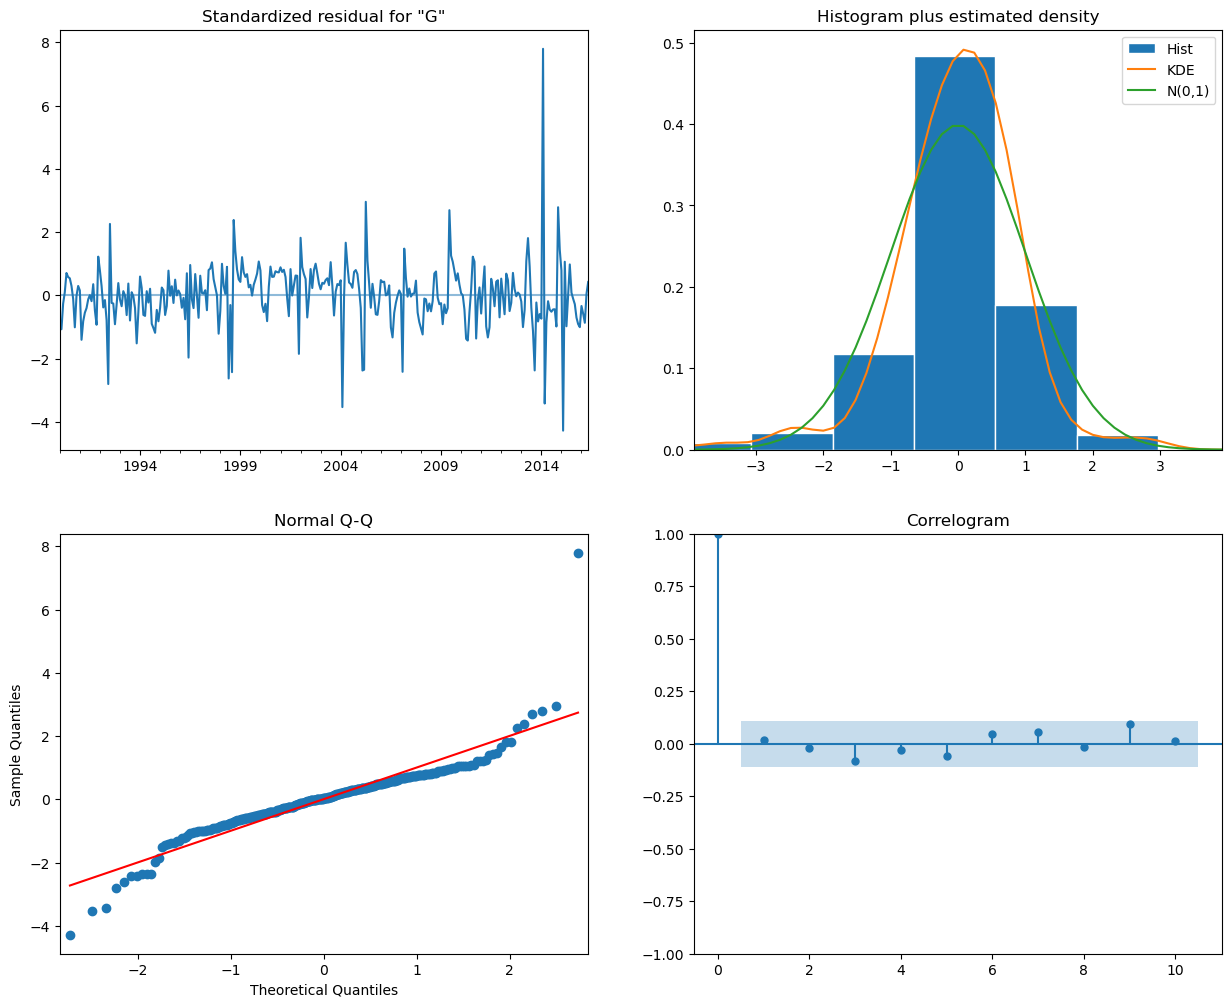

                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 1, 1)   Log Likelihood               -1915.981
Date:                      Thu, 10 Aug 2023   AIC                           3837.961
Time:                              23:23:51   BIC                           3849.228
Sample:                          01-01-1990   HQIC                          3842.462
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3952      0.050      7.891      0.000       0.297       0.493
ma.L1         -0.9167      0.026    -34.879      0.000      -0.968      -0.865
sigm

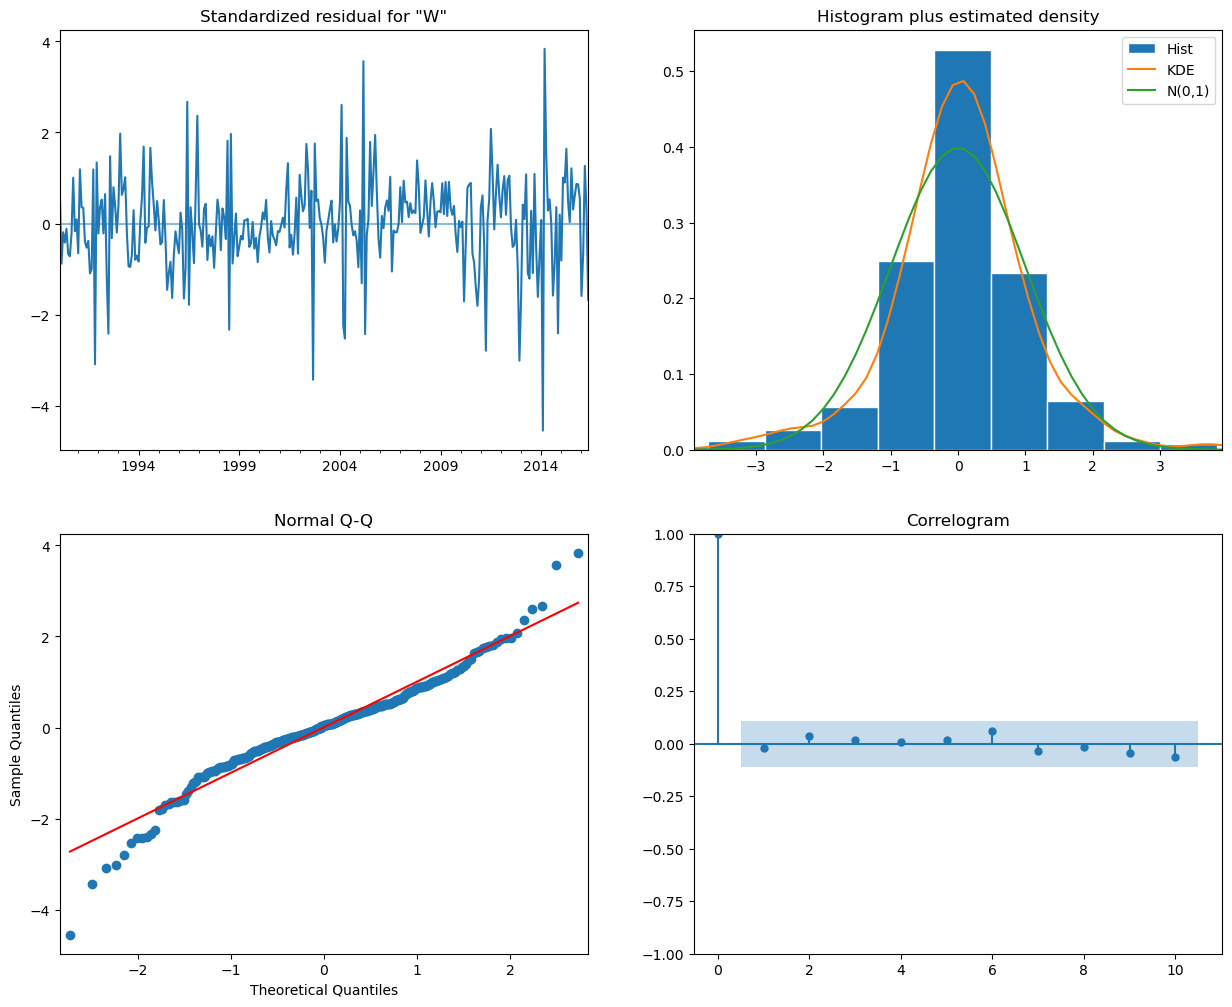

                                     SARIMAX Results                                     
Dep. Variable:     Electricity Consumption (MWh)   No. Observations:                  317
Model:                            ARIMA(1, 1, 1)   Log Likelihood               -1750.289
Date:                           Thu, 10 Aug 2023   AIC                           3506.578
Time:                                   23:23:52   BIC                           3517.845
Sample:                               01-01-1990   HQIC                          3511.079
                                    - 05-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0470      0.101      0.466      0.641      -0.151       0.245
ma.L1          0.5738      0.075      7.696

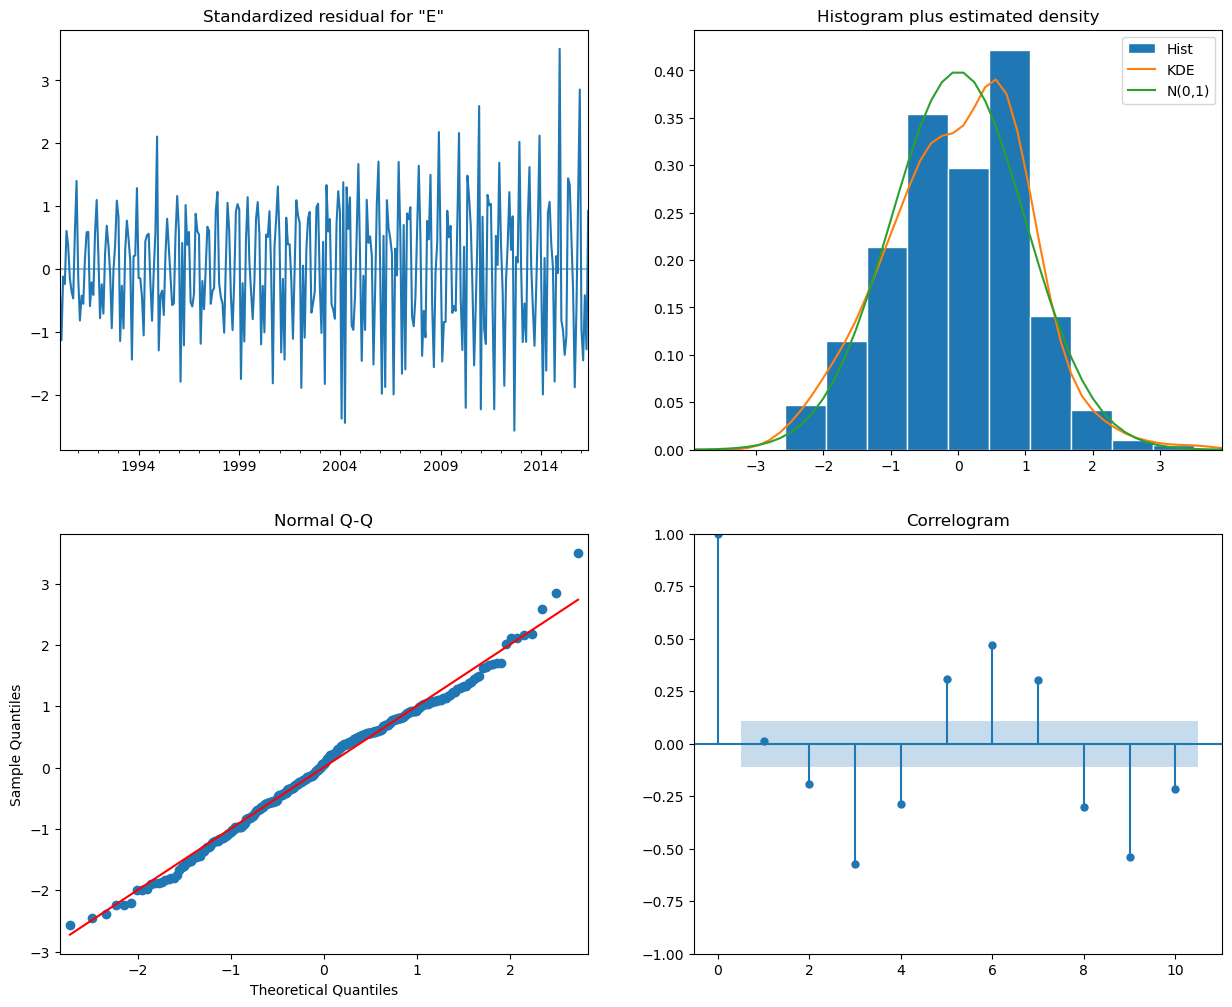

In [28]:
model_Arr = []
for i in range(len(consumption_train)):
    if i == 0:
        model_Arr.append(ARIMA(endog=consumption_train[i], order=(1, 0, 1)).fit())
    else:
        model_Arr.append(ARIMA(endog=consumption_train[i], order=(1, 1, 1)).fit())
    print(model_Arr[i].summary())
    model_Arr[i].plot_diagnostics(figsize=(15, 12))
    plt.show()

### How do we interpret our results?

The categories we need to look out for is the P>|z|, Ljung-Box (L1) (Q), Heteroskedasticity (H), Jarque-Bera tests, Log likelihood, Akaike’s Information Criterion (AIC), Bayesian Information Criterion (BIC) and Residuals.

__P>|z|__ column, it represents the term significance using a hypothesis testing with the following hypothesis

- $H_0$: Each coefficient is NOT statistically significant
- $H_1$: Each coefficient is statistically significant

The __Ljung-Box (L1) (Q)__ is the LBQ test statistic at lag 1. It is used as a hypothesis testing for the following hypothesis

- $H_0$: The errors are white noise
- $H_1$: The errors are not white noise

__Heteroskedasticity (H)__ tests that the error residuals are homoscedastic or have the same variance.

- $H_0$: The residuals show variances
- $H_1$: The residuals show no variances

__Jarque-Bera tests__ for the normality of errors.

- $H_0$: Data is normally distributed against an alternative of another distribution
- $H_1$: Data is not normally distributed against an alternative of another distribution

The __log-likelihood__ function identifies a distribution that fits best with the sampled data.

__Akaike’s Information Criterion (AIC)__ helps determine the strength of the linear regression model. The AIC penalizes a model for adding parameters since adding more parameters will always increase the maximum likelihood value.

__Bayesian Information Criterion (BIC)__, like the AIC, also punishes a model for complexity, but it also incorporates the number of rows in the data.

__Hannan-Quinn Information Criterion (HQIC)__, like AIC and BIC, is another criterion for model selection; however, it’s not used as often in practice.

Residuals

The difference between the observations and the corresponding fitted values.

$$
e_{t} = y_{t} - \hat{y}_{t}
$$

[Source](https://analyzingalpha.com/interpret-arima-results)

#### Individual Obseravations for Consumption (ARIMA)

__Gas Consumption__
- All the coefficients are statiscally significant
- The errors are white noise
- Residuals show variance
- Data is not normally distributed against an alternative of another distribution

We can see that the kde line follows a normal distribution, with he N(0,1) line being smaller. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples. The residuals over time plot don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.


__Water Consumption__
- All coeffiecients are statistically sigificant
- The errors are white noise
- Residuals do not show variance
- Data is not normally distributed against an alternative of another distribution

We can see that the kde line follows a normal distribution. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples . The residuals over time plot don’t display any obvious seasonality. This is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

__Electricity Consumption__
- ar.L1 is not statiscally significant, while ma.L1 and sigma2 are statistically significant.
- The errors are white noise
- Residuals do show variance
- Data is normally distributed against an alternative of another distribution

We can see that the kde line does not follow a normal distribution, with the N(0,1) line being normal distribution. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples. The residuals over time plot does display  seasonality and does not appear to be white noise. This is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have high correlation with some lagged versions of itself.

### Visualizing the Predictions

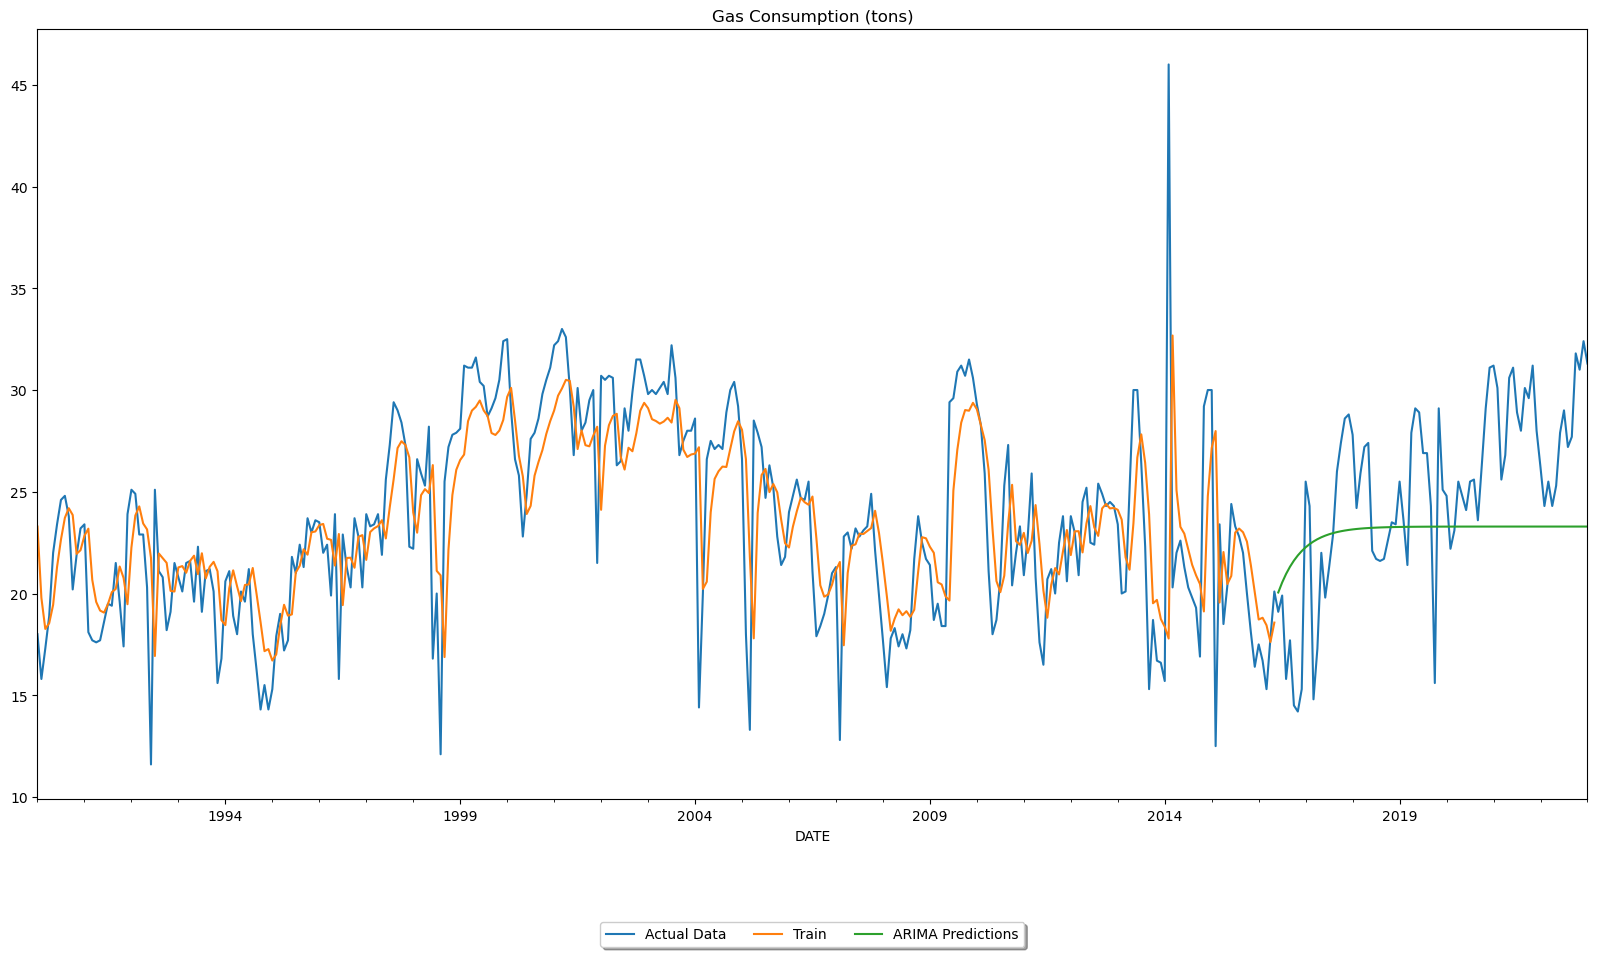

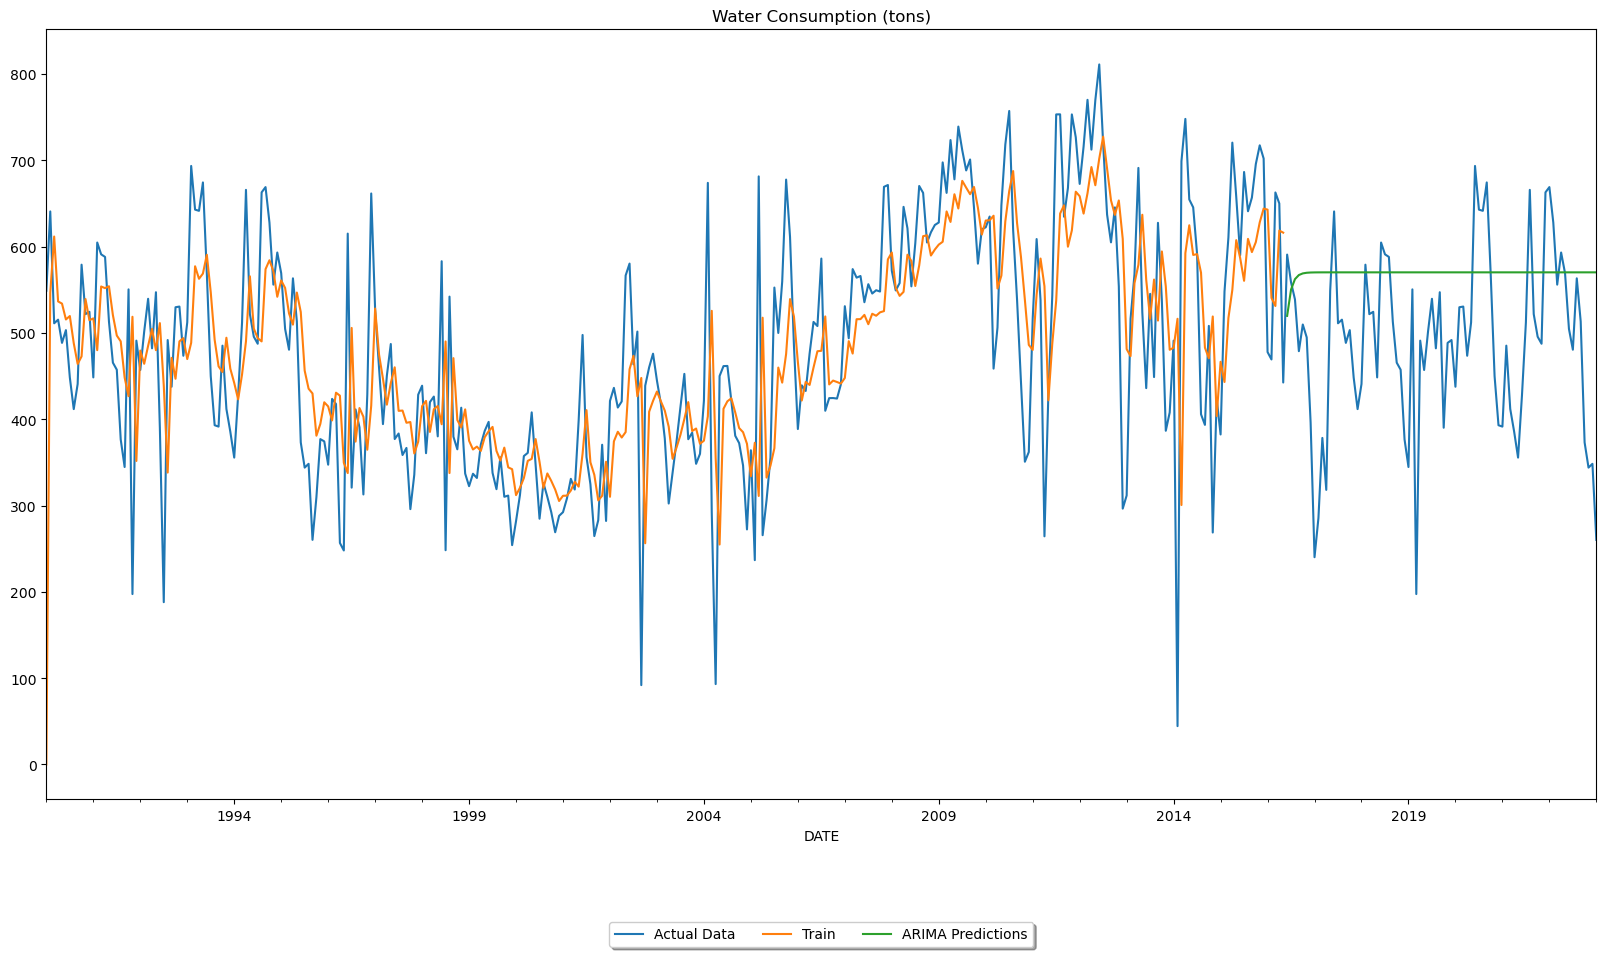

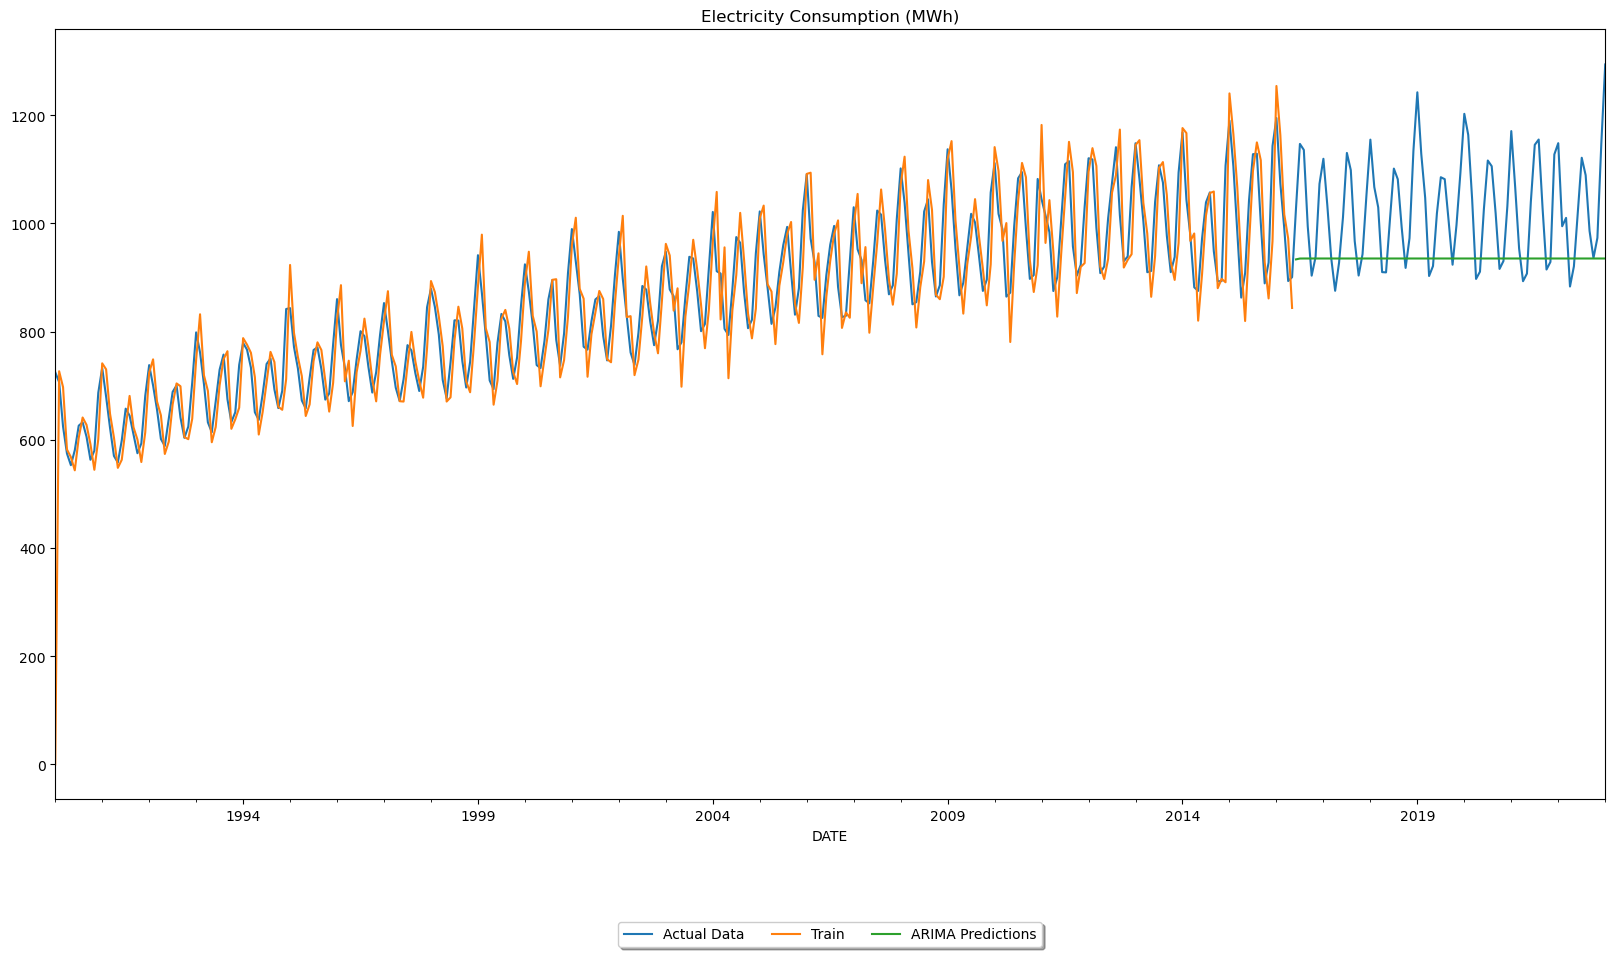

In [29]:
ARIMAmodels = [
    ARIMA(gasConsumption_train, order=(1, 0, 1)).fit(),
    ARIMA(waterConsumption_train, order=(1, 1, 1)).fit(),
    ARIMA(electricityConsumption_train, order=(1, 1, 1)).fit()
]


labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']
for i in range(len(labels)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    fullPred = ARIMAmodels[i].predict()
    pred = ARIMAmodels[i].forecast(df_test.shape[0])
    df[labels[i]].plot(ax=ax, label="Actual Data")
    fullPred.plot(ax=ax, label="Train")
    pred.plot(ax=ax, label="ARIMA Predictions")
    plt.title(labels[i])
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
    )
    plt.show()

__Observations:__
- We can see that for all the time series predictions made by ARIMA, the model is struggling to accurately forecast the future values of the time series data.
- However it does try to predict the trend, but only for the first 2-3 months then the results fall into a straight line.

__Why does this happen?__

This can be due to serveral factors in the ARIMA model.
- ARIMA focuses more on short term trends rather than long term trends.
- It does not handle seasonal time series data well
- Difficult to predict turning points

[[17]](https://www.capitalone.com/tech/machine-learning/understanding-arima-models/)

## SARIMA

### How do we get the seasonal order?
We look at the seasonal lags of our ACF and PACF graphs. When the PACF is decaying expotentially at the seasonal lags, and at the ACF there is a spike at one of the seasonal lag. We can conclude that Q = 1. On the other hand when the ACF is decaying expotentially at the seasonal lags, and at the PACF there is a spike at one of the seasonal lag, we can conclude that P = 1

__Seasonal Order for Consumption Time series__
- Gas consumption
    - (1,0,0,12)
- Water consumption
    - (1,1,0,12)
- Electricity consumption
    - (1,1,0,12)

[Source](https://www.youtube.com/watch?v=N2AVuGV-eQk&ab_channel=Dr.ImranArif)

                                      SARIMAX Results                                      
Dep. Variable:              Gas Consumption (tons)   No. Observations:                  317
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -866.677
Date:                             Thu, 10 Aug 2023   AIC                           1741.353
Time:                                     23:23:53   BIC                           1756.389
Sample:                                 01-01-1990   HQIC                          1747.359
                                      - 05-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9972      0.004    256.050      0.000       0.990       1.005
ma.L1         -0.5321      

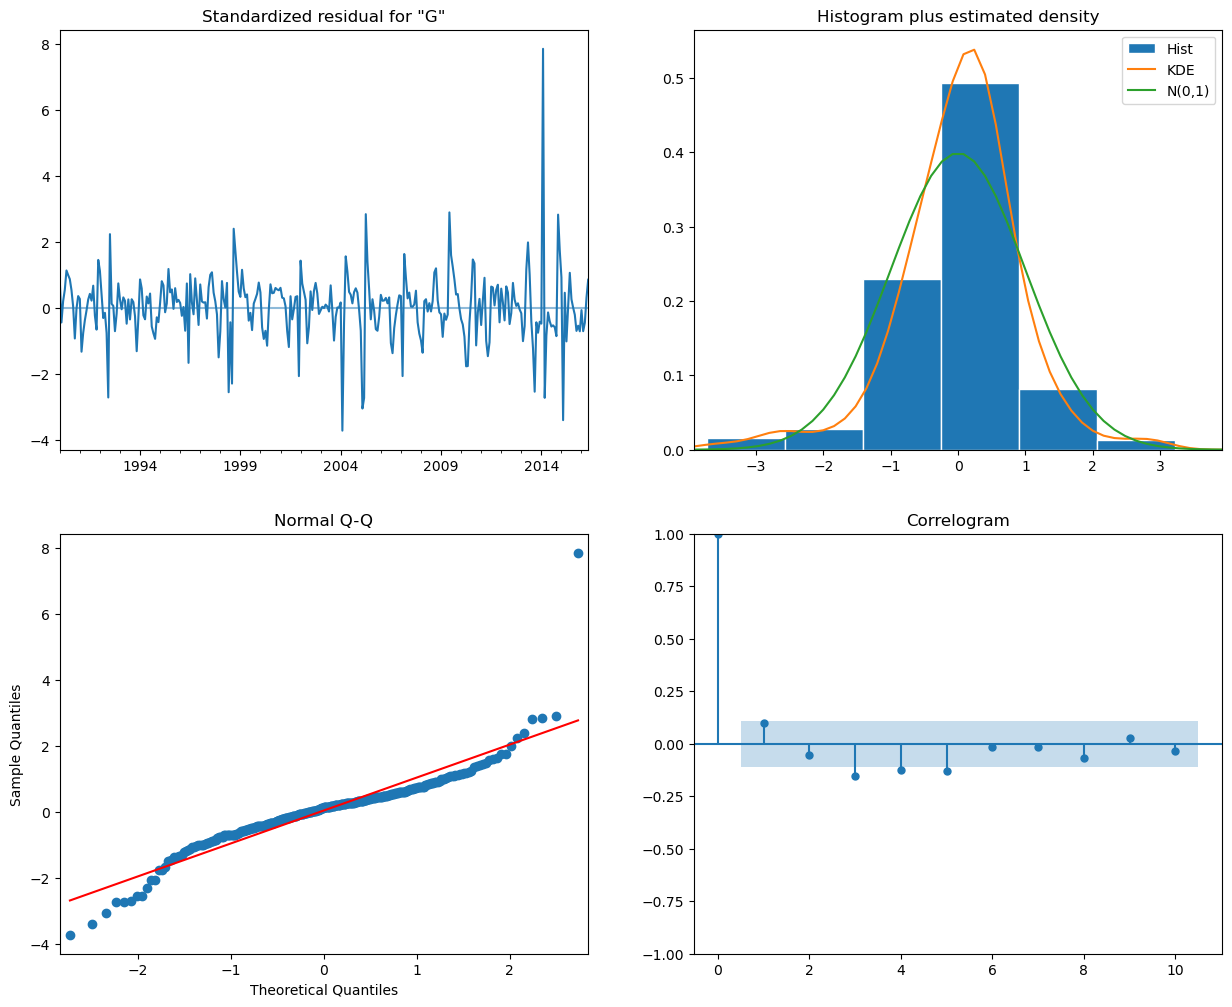

                                      SARIMAX Results                                      
Dep. Variable:            Water Consumption (tons)   No. Observations:                  317
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1887.717
Date:                             Thu, 10 Aug 2023   AIC                           3783.434
Time:                                     23:23:54   BIC                           3798.302
Sample:                                 01-01-1990   HQIC                          3789.381
                                      - 05-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4944      0.043     11.451      0.000       0.410       0.579
ma.L1         -0.9986      

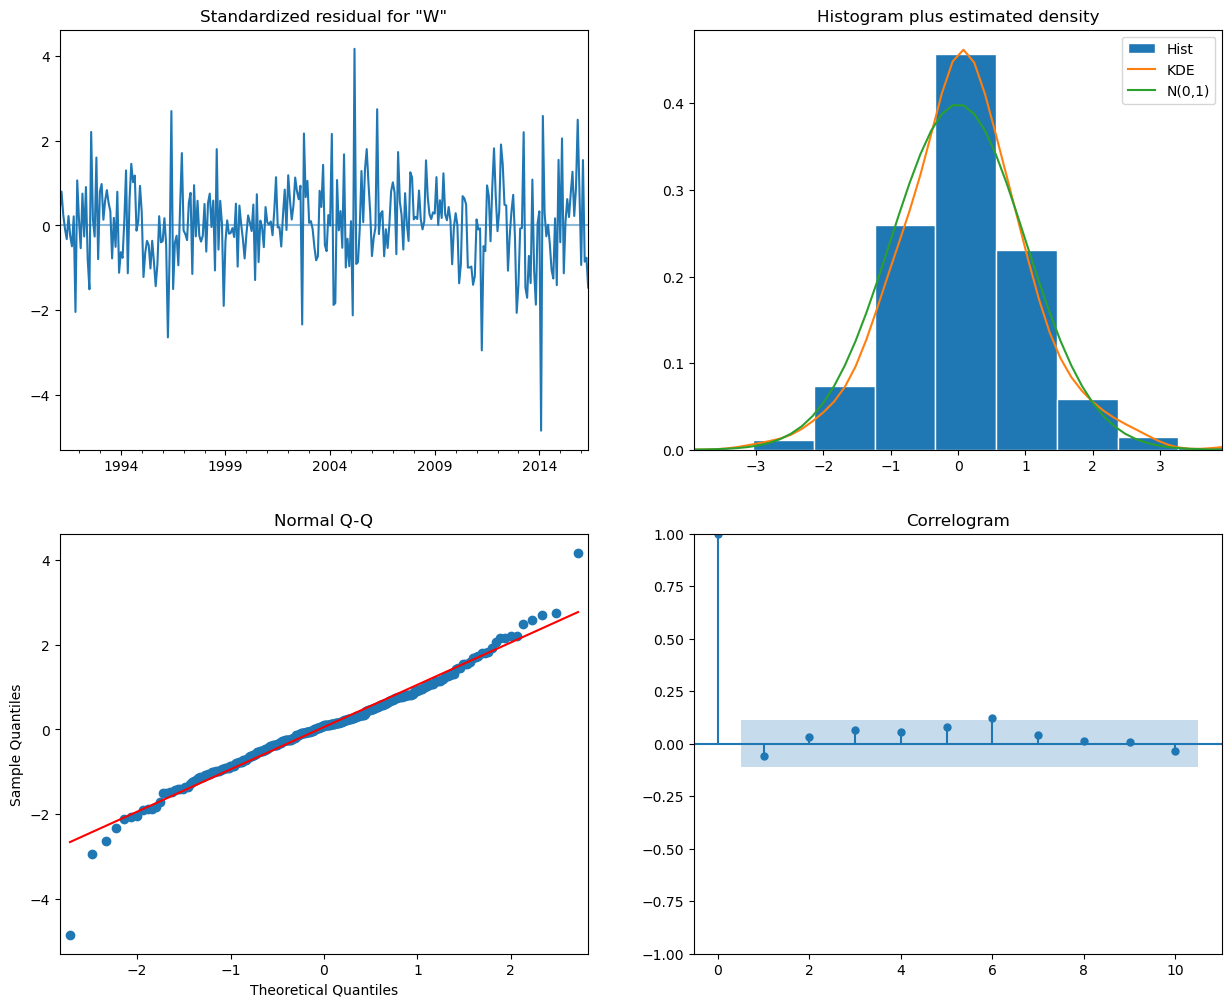

                                      SARIMAX Results                                      
Dep. Variable:       Electricity Consumption (MWh)   No. Observations:                  317
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1402.534
Date:                             Thu, 10 Aug 2023   AIC                           2813.068
Time:                                     23:23:55   BIC                           2827.936
Sample:                                 01-01-1990   HQIC                          2819.015
                                      - 05-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5172      0.049     10.529      0.000       0.421       0.613
ma.L1         -0.9834      

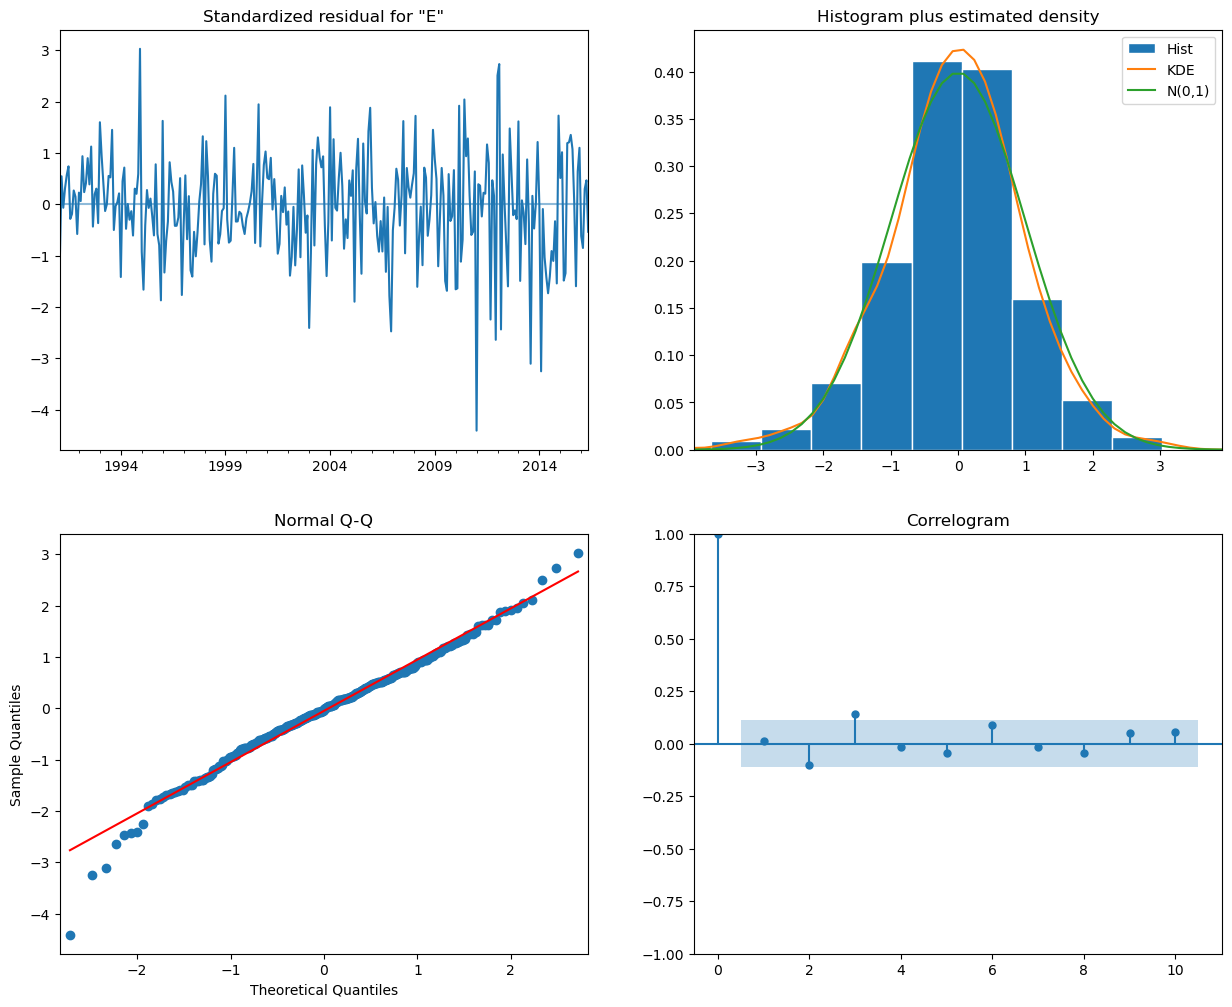

In [30]:
model_Arr = []
for i in range(len(consumption_train)):
    if i == 0:
        model_Arr.append(SARIMAX(endog=consumption_train[i], order=(1, 0, 1),seasonal_order=(1,0,0,12)).fit())
    else:
        model_Arr.append(SARIMAX(endog=consumption_train[i], order=(1, 1, 1),seasonal_order=(1,1,0,12)).fit())
    print(model_Arr[i].summary())
    model_Arr[i].plot_diagnostics(figsize=(15, 12))
    plt.show()

#### Individual Obseravations for Consumption (SARIMA)

__Gas Consumption__
- All the coefficients are statiscally significant
- The errors are white noise
- Residuals do not show variance
- Data is not normally distributed against an alternative of another distribution

We can see that the kde line follows a normal distribution, with he N(0,1) line being much smaller. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples. The residuals over time plot don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.


__Water Consumption__
- All coeffiecients are statistically sigificant
- The errors are white noise
- Residuals do not show variance
- Data is not normally distributed against an alternative of another distribution

We can see that the kde line follows a normal distribution with the N(0,1) line being slightly smaller. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples . The residuals over time plot don’t display any obvious seasonality. This is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

__Electricity Consumption__
- All coefficients are statistically significant
- The errors are white noise
- Residuals do show variance
- Data is not normally distributed against an alternative of another distribution

We can see that the kde line does follow a normal distribution together with the N(0,1) line. The qq-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples. The residuals over time plot does not seem to display  seasonality and appears to be white noise. This is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### Visualizing the Predictions

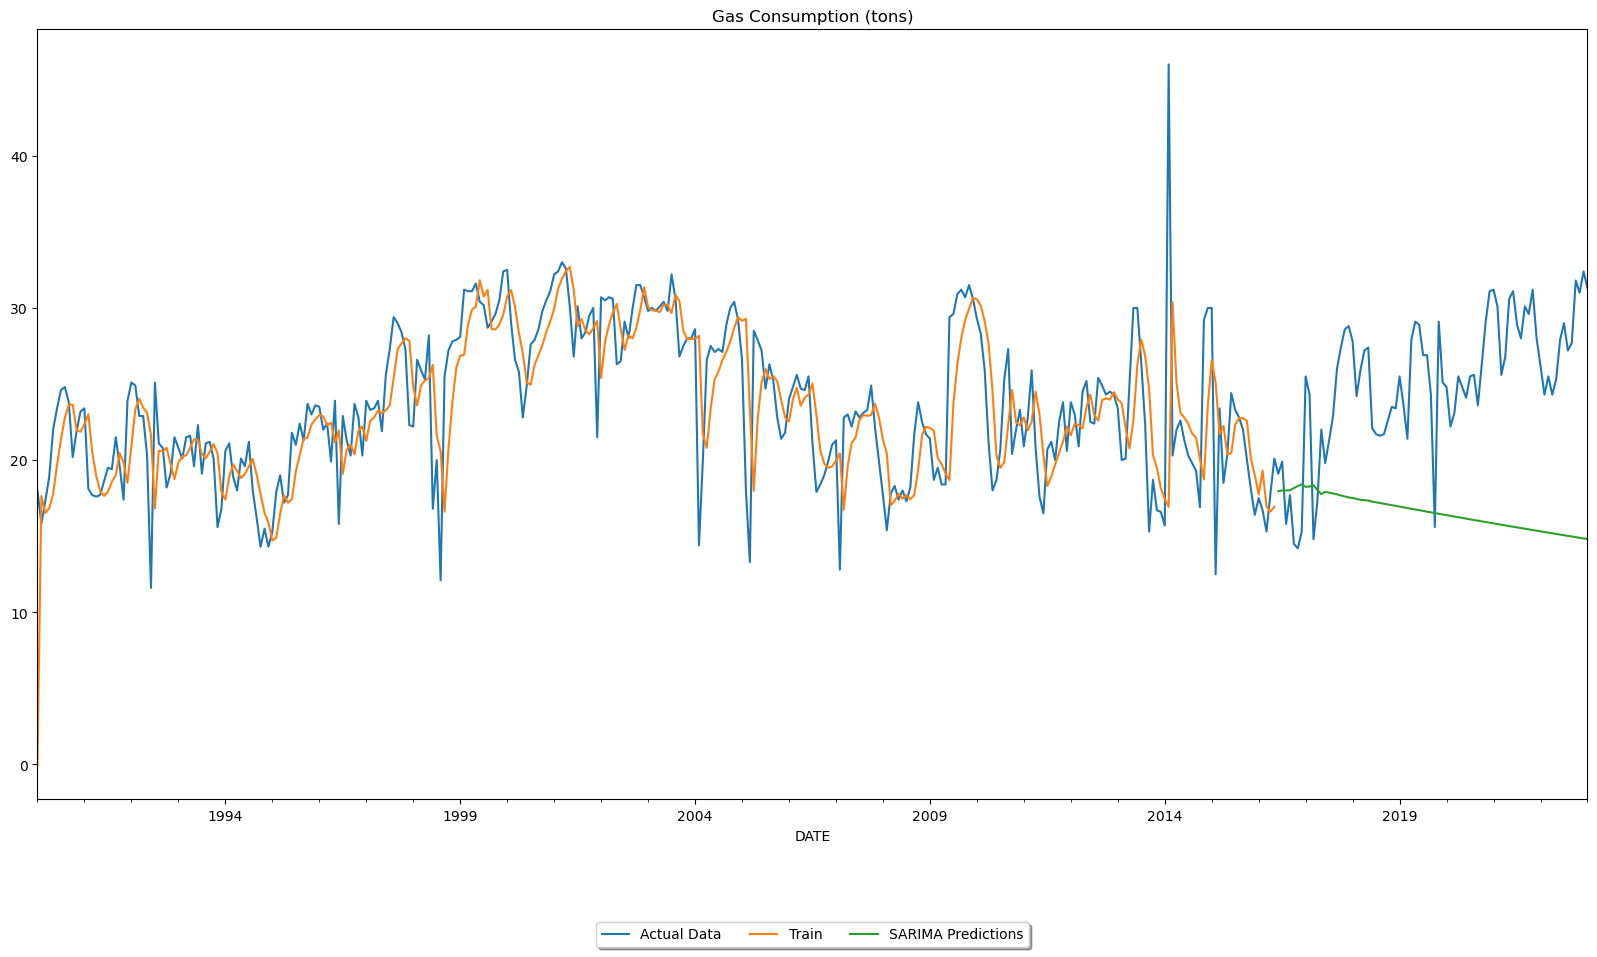

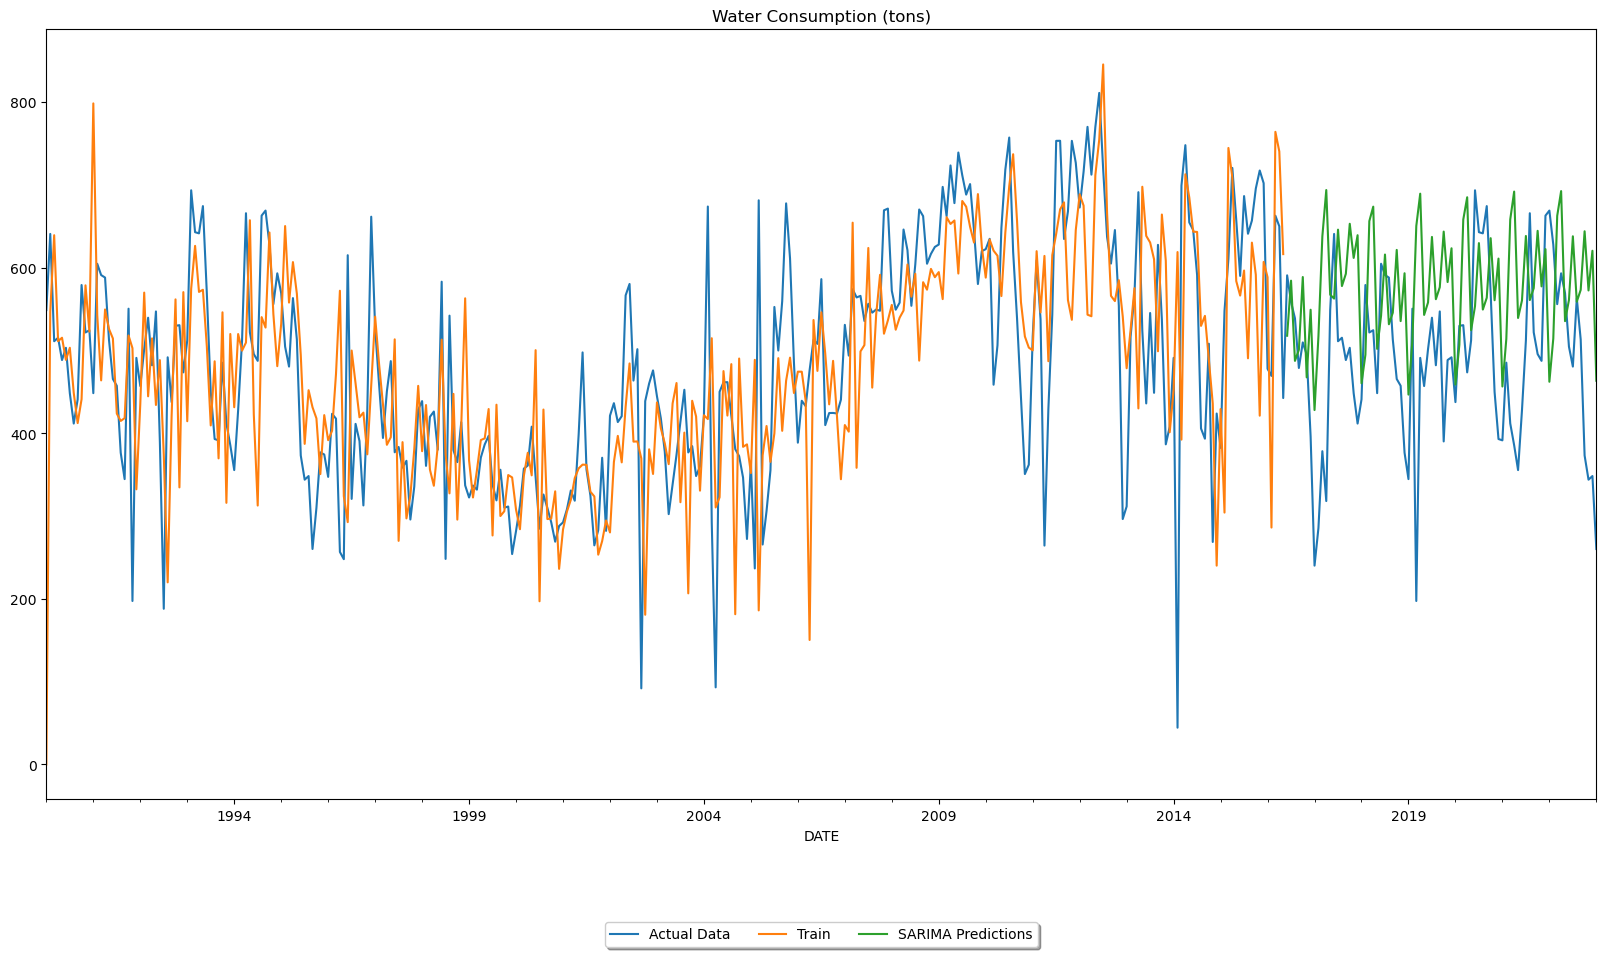

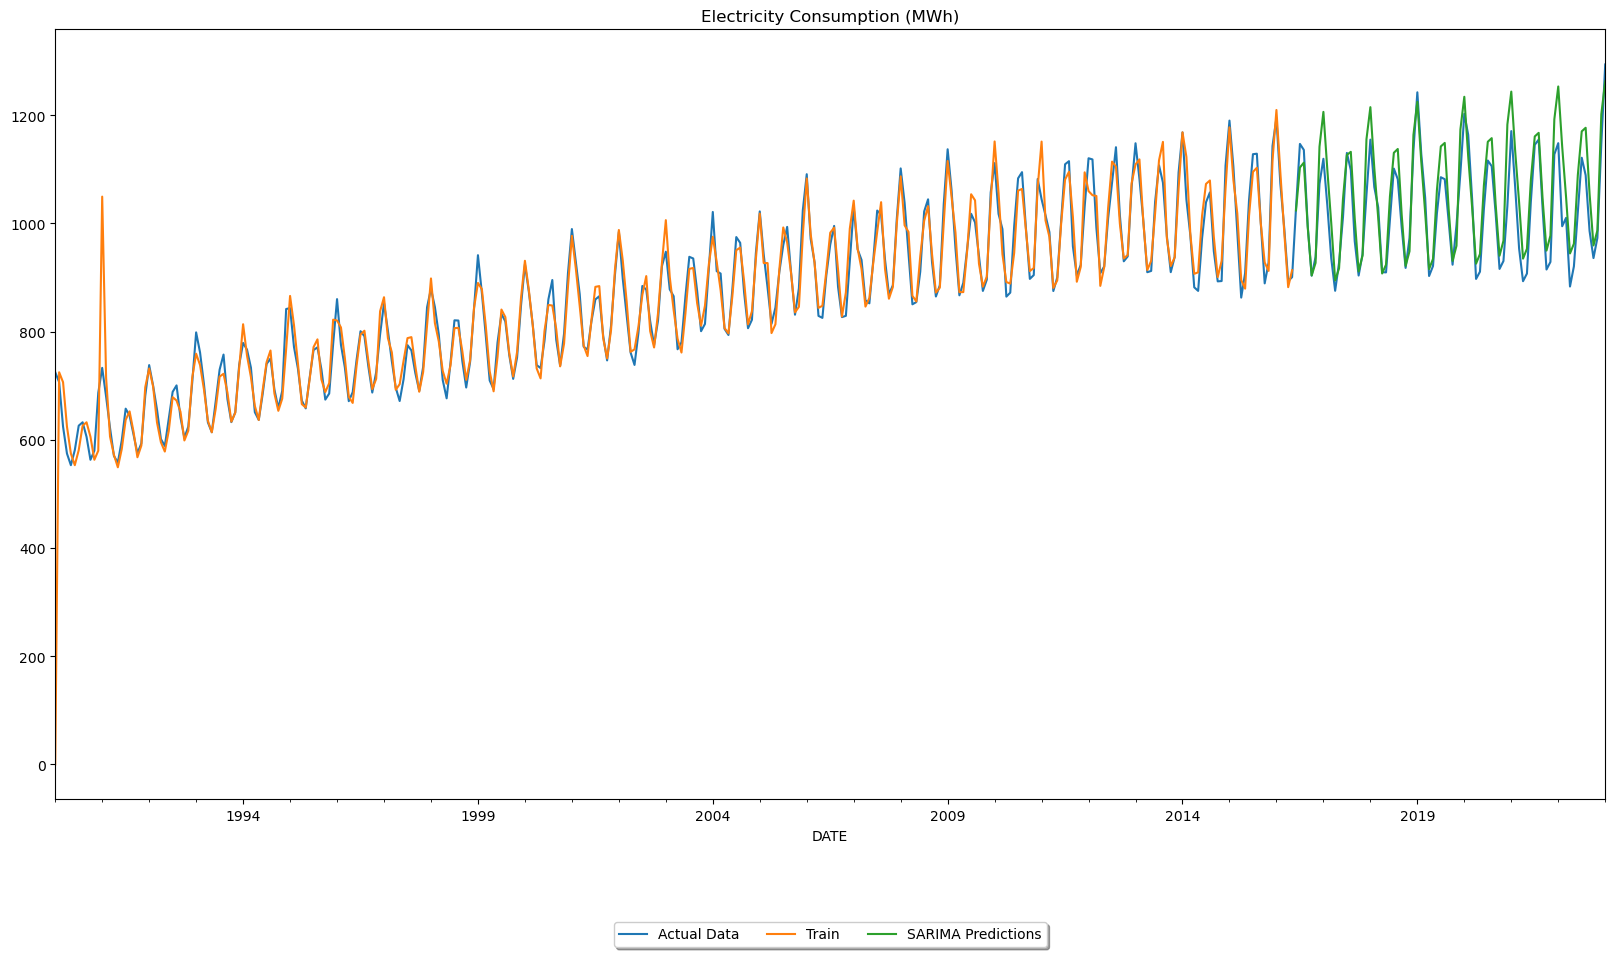

In [31]:
SARIMAmodels = [
    SARIMAX(gasConsumption_train, order=(1, 0, 1),seasonal_order=(1,0,0,12)).fit(),
    SARIMAX(waterConsumption_train, order=(1, 1, 1),seasonal_order=(1,1,0,12)).fit(),
    SARIMAX(electricityConsumption_train, order=(1, 1, 1),seasonal_order=(1,1,0,12)).fit()
]


labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']
for i in range(len(labels)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    fullPred = SARIMAmodels[i].predict()
    pred = SARIMAmodels[i].forecast(df_test.shape[0])
    df[labels[i]].plot(ax=ax, label="Actual Data")
    fullPred.plot(ax=ax, label="Train")
    pred.plot(ax=ax, label="SARIMA Predictions")
    plt.title(labels[i])
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
    )
    plt.show()

SARIMA vs ARIMA

We can see visually from the graphs that SARIMA is better than ARIMA, with it including seasonality in its predictions. Another way to compare this 2 models is to look at the AIC and BIC. The lower the values, the better the model is.

#### Whats AIC and BIC?

__AIC (Akaike Information Criterion)__
- It is the trade off between the goodness of fit of a modeland its complexity. It takes into account both how well the model fits the data and the number of parameters in the model.

__BIC (Bayesian Information Criterion)__
- It is similiar to AIC, but with a a penalty term for the number of parameters that are estimated in the model. 

Looking at the summary of ARIMA and SARIMA models, the SARIMA model performs better with a decrease in AIC and BIC score of around 100 for water consumption and around 1000 for Electricity consumption. With Gas consumption being worse with a increase of around 20 in AIC and BIC

### SARIMA vs ARIMA
We will be using metrics used in regression, as time series is quite similiar to a regression problem. The 2 main scoring metrics we will be using is:

__RMSE__
- RMSE is the root of MSE, we will be using RMSE and MSE values can sometimes get too large to proprely compare

__MAPE__
- MAPE is measures the average percentage difference between the predicted values and the actual values of a time series.

In [32]:
results = []

labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

for i in range(len(ARIMAmodels)):
    arima_pred = ARIMAmodels[i].forecast(steps=len(df_test))
    sarima_pred = SARIMAmodels[i].forecast(steps=len(df_test))

    arima_rmse = np.sqrt(mean_squared_error(df_test[labels[i]], arima_pred))
    arima_mape = calculate_mape(df_test[labels[i]], arima_pred)
    arima_aic = ARIMAmodels[i].aic
    arima_bic = ARIMAmodels[i].bic

    sarima_rmse = np.sqrt(mean_squared_error(df_test[labels[i]], sarima_pred))
    sarima_mape = calculate_mape(df_test[labels[i]], sarima_pred)
    sarima_aic = SARIMAmodels[i].aic
    sarima_bic = SARIMAmodels[i].bic

    results.append((f"{labels[i]}", "ARIMA", arima_rmse, arima_mape, arima_aic, arima_bic))
    results.append((f"{labels[i]}", "SARIMA", sarima_rmse, sarima_mape, sarima_aic, sarima_bic))

columns = ["Model", "Method", "RMSE", "MAPE", "AIC", "BIC"]
results = pd.DataFrame(results, columns=columns)

display(results)

Model  Method        RMSE       MAPE          AIC  \
0         Gas Consumption (tons)   ARIMA    4.571405  15.445731  1724.029667   
1         Gas Consumption (tons)  SARIMA    9.995938  33.961613  1741.353448   
2       Water Consumption (tons)   ARIMA  130.270579  26.610039  3837.961223   
3       Water Consumption (tons)  SARIMA  149.070731  29.525609  3783.433844   
4  Electricity Consumption (MWh)   ARIMA  132.654262   9.571921  3506.577563   
5  Electricity Consumption (MWh)  SARIMA   50.238485   3.876306  2813.067777   

           BIC  
0  1739.065274  
1  1756.389055  
2  3849.228449  
3  3798.301955  
4  3517.844790  
5  2827.935888

__Observations:__
- The results for Gas Consumption and Electricity consumption make sense for its RMSE, MAPE, AIC and BIC values.
- However Water consumption has `somewhat contradictory results` :( with its ARIMA RMSE and MAPE values being better then SARIMA. While SARIMA has better AIC and BIC values.
    - I dont think its a bug or a model problem, but how we interpret our results and what do we want the model to achieve. 
    - Both RMSE and MAPE tells us how well the model is performing in terms of forecasting accuracy, with a lower value indicating better predictive performance. Suggesting that ARIMA has a more accurate forecast as compared to SARIMA
    - AIC and BIC take into account both the goodness of fit and the complexity of the model. A lower AIC or BIC indicates a better balance between model fit and complexity. Suggesting that SARIMA has a better fit comapred to ARIMA.

## Cross Validation using the Expanding Window Technique
It is a method used to evaluate models by progressively increasing the size of the training dataset over time. It allows you to use all available historical data up to a certain point to make predictions for the future.

We start with a small initial training dataset and then gradually include more historical data as you move forward in time. This means that our training dataset becomes larger with each iteration.The advantage of this approach is that our model is exposed to a wider range of historical patterns as it makes predictions further into the future.[[17]](https://robotwealth.com/rolling-and-expanding-windows-for-dummies/)

This technique contrasts with the rolling window approach, where only a fixed-size window of data is used for training and the window moves forward in time.

![](./images/expandingwindow.webp)

A : Rolling Window  B : Expanding Window [[Source]](https://medium.com/@philippetousignant/forecasting-with-python-expanding-and-rolling-window-fa0be5545940#:~:text=Expanding%20window%20refers%20to%20a,of%20data%20in%20our%20model.)

In [33]:
from sklearn.metrics import mean_absolute_percentage_error
SARIMAmodels = [
    SARIMAX(gasConsumption_train, order=(1, 0, 1),seasonal_order=(1,0,0,12)).fit(),
    SARIMAX(waterConsumption_train, order=(1, 1, 1),seasonal_order=(1,1,0,12)).fit(),
    SARIMAX(electricityConsumption_train, order=(1, 1, 1),seasonal_order=(1,1,0,12)).fit()
]
ARIMAmodels = [
    ARIMA(gasConsumption_train, order=(1, 0, 1)).fit(),
    ARIMA(waterConsumption_train, order=(1, 1, 1)).fit(),
    ARIMA(electricityConsumption_train, order=(1, 1, 1)).fit()
]
labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']
n_splits = 5


results_df = pd.DataFrame(columns=[
    'Fold', 'Time Series', 'ARIMA_RMSE', 'SARIMA_RMSE', 
    'ARIMA_MAPE', 'SARIMA_MAPE', 'ARIMA_AIC', 'ARIMA_BIC', 
    'SARIMA_AIC', 'SARIMA_BIC'
])

tscv = TimeSeriesSplit(n_splits=n_splits)
fold_count = 0
for train_index, valid_index in tscv.split(df_test):
    fold_count += 1
    fold_results = []

    train_data = df_train.iloc[train_index]
    valid_data = df_test.iloc[valid_index]

    for j in range(len(ARIMAmodels)):
        train_column = labels[j]

        if labels[j] == 'Gas Consumption (tons)':
            ARIMAmodels[j] = ARIMA(train_data[train_column], order=(1, 0, 1)).fit()
            SARIMAmodels[j] = SARIMAX(train_data[train_column], order=(1, 0, 1), seasonal_order=(1, 0, 0, 12)).fit()
        else:
            ARIMAmodels[j] = ARIMA(train_data[train_column], order=(1, 1, 1)).fit()
            SARIMAmodels[j] = SARIMAX(train_data[train_column], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)).fit()

        arima_pred = ARIMAmodels[j].forecast(steps=len(valid_data))
        sarima_pred = SARIMAmodels[j].forecast(steps=len(valid_data))

        arima_rmse = np.sqrt(mean_squared_error(valid_data[train_column], arima_pred))
        sarima_rmse = np.sqrt(mean_squared_error(valid_data[train_column], sarima_pred))
        arima_mape = mean_absolute_percentage_error(valid_data[train_column], arima_pred)
        sarima_mape = mean_absolute_percentage_error(valid_data[train_column], sarima_pred)

        arima_aic = ARIMAmodels[j].aic
        arima_bic = ARIMAmodels[j].bic
        sarima_aic = SARIMAmodels[j].aic
        sarima_bic = SARIMAmodels[j].bic

        fold_results.append({
            "Fold": fold_count,
            "Time Series": labels[j],
            "ARIMA_RMSE": arima_rmse,
            "SARIMA_RMSE": sarima_rmse,
            "ARIMA_MAPE": arima_mape,
            "SARIMA_MAPE": sarima_mape,
            "ARIMA_AIC": arima_aic,
            "ARIMA_BIC": arima_bic,
            "SARIMA_AIC": sarima_aic,
            "SARIMA_BIC": sarima_bic
        })
    results_df = results_df.append(fold_results, ignore_index=True)

column_order = [
    'Fold', 'Time Series', 'ARIMA_RMSE', 'SARIMA_RMSE', 
    'ARIMA_MAPE', 'SARIMA_MAPE', 'ARIMA_AIC', 'ARIMA_BIC', 
    'SARIMA_AIC', 'SARIMA_BIC'
]
results_df = results_df[column_order]

results_df

Fold                    Time Series  ARIMA_RMSE  SARIMA_RMSE  ARIMA_MAPE  \
0     1         Gas Consumption (tons)    5.918041     6.533239    0.193826   
1     1       Water Consumption (tons)   64.379559   352.045835    0.111765   
2     1  Electricity Consumption (MWh)  431.056548   423.647721    0.416583   
3     2         Gas Consumption (tons)    5.018397     3.826561    0.171170   
4     2       Water Consumption (tons)  110.613563   118.944942    0.248144   
5     2  Electricity Consumption (MWh)  496.280999   399.106211    0.467245   
6     3         Gas Consumption (tons)    5.161146     6.340971    0.183375   
7     3       Water Consumption (tons)  131.939364    73.001118    0.227427   
8     3  Electricity Consumption (MWh)  400.068876   336.802661    0.370539   
9     4         Gas Consumption (tons)    9.269005    10.425842    0.306655   
10    4       Water Consumption (tons)   96.749136   114.845309    0.166812   
11    4  Electricity Consumption (MWh)  332.837080   311.191199    0.303421   
12    5         Gas Consumption (tons)    8.553517     8.578482    0.280678   
13    5       Water Consumption (tons)  132.844033   139.776399    0.259914   
14    5  Electricity Consumption (MWh)  284.355307   297.999494    0.244076   

    SARIMA_MAPE   ARIMA_AIC   ARIMA_BIC  SARIMA_AIC  SARIMA_BIC  
0      0.246313   71.287985   74.120186   76.124280   78.956480  
1      0.686413  163.983727  165.900899   30.573546   25.346135  
2      0.408567  145.901376  147.818548   25.158094   19.930683  
3      0.125941  126.048968  131.377786  134.591779  139.920597  
4      0.231393  325.747252  329.634762  188.100866  190.933067  
5      0.372074  275.170883  279.058394  130.626808  133.459009  
6      0.226275  205.552913  212.407201  217.097164  223.951453  
7      0.121349  489.061212  494.127850  349.389979  354.718797  
8      0.308094  409.487467  414.554105  237.788258  243.117076  
9      0.347085  261.158145  269.114082  276.051142  284.007079  
10     0.201572  640.966466  646.877342  506.084386  512.938674  
11     0.289947  544.649090  550.559966  349.206558  356.060846  
12     0.280872  320.548793  329.367564  334.920586  343.739357  
13     0.277477  792.392141  798.961106  666.727009  674.682945  
14     0.262751  686.311108  692.880072  477.276444  485.232380

__Observations__

__RMSE__
- For gas consumption, the RMSE values for both ARIMA and SARIMA are relatively close.
- For water consumption, SARIMA generally has higher RMSE values compared to ARIMA.
- For electricity consumption, both ARIMA and SARIMA have similar RMSE values.

__MAPE__
- The values for both ARIMA and SARIMA are somewhat close across all consumption categories and folds. With SARIMA doing generally better

__AIC and BIC__
- SARIMA has generally lower values for AIC and BIC, indicating a better balance between model fit and complexity

__Gas Consumption__
- The RMSE and MAPE values for gas consumption are relatively consistent across different folds, suggesting stable performance for both models over time.

__Water Consumption__
-SARIMA tends to have higher RMSE and MAPE values for water consumption, which might indicate that ARIMA captures certain patterns more effectively.

__Electricity Consumption__
- The performance of ARIMA and SARIMA for electricity consumption is similar in terms of RMSE and MAPE values.

## Holt-Winters' Seasonal Smoothing model
It is also known as triple exponential smoothing, as it combines all 3 of the smoothing methods bulit on top of each other.[[18]](https://medium.com/analytics-vidhya/a-thorough-introduction-to-holt-winters-forecasting-c21810b8c0e6).It is designed to handle time series data that exhibits both a trend and a seasonal variation. The method is named after its contributors, Charles Holt and Peter Winters.

It models 3 aspects of a time series[[19]](https://orangematter.solarwinds.com/2019/12/15/holt-winters-forecasting-simplified/)

We will be using the `Additive method` as our variance does not change as the mean changes (from the previous STL anaylsis)

__Level__
- Represents the baseline or average value of the time series. It captures the overall behavior or central tendency of the data.
$$
\ell_t = \alpha \cdot (y_t - s_{t-m}) + (1 - \alpha) \cdot (\ell_{t-1} + b_{t-1})
$$

__Trend__
- Captures the direction and  magnitude of the overall trend in the data. It accounts for changes in the data that occur over time.
$$
b_t = \beta \cdot (\ell_t - \ell_{t-1}) + (1 - \beta) \cdot b_{t-1}
$$

__Seasonality__
- Represents the repeating pattern or cycle of the data that occurs at regular intervals. It captures the periodic variations in the time series.
$$
s_t = \gamma \cdot (y_t - \ell_t) + (1 - \gamma) \cdot s_{t-m}
$$

__Forecast Equation__
$$
\hat{y}_{t+h} = \ell_t + h \cdot b_t + s_{t-m+h\mod m}
$$

In [34]:
from IPython.core.interactiveshell import InteractiveShell
HWmodels = [
    ExponentialSmoothing(gasConsumption_train, trend="add",seasonal="add",seasonal_periods=12).fit(),
    ExponentialSmoothing(waterConsumption_train, trend="add",seasonal="add",seasonal_periods=12).fit(),
    ExponentialSmoothing(electricityConsumption_train, trend="add",seasonal="add",seasonal_periods=12).fit()
]

model_Arr = []
for i in range(len(consumption_train)):
    model_Arr.append(ExponentialSmoothing(consumption_train[i], trend="add",seasonal="add",seasonal_periods=12).fit()),
    print(model_Arr[i].summary())
    plt.show()

results = []
for i in range(len(HWmodels)):
    HW_pred = HWmodels[i].forecast(steps=len(df_test))
    HW_rmse = np.sqrt(mean_squared_error(df_test[labels[i]], HW_pred))
    HW_mape = calculate_mape(df_test[labels[i]], HW_pred)
    HW_aic = HWmodels[i].aic
    HW_bic = HWmodels[i].bic

    results.append((f"{labels[i]}",HW_rmse, HW_mape, HW_aic, HW_bic))

columns = ["Time Series","RMSE", "MAPE", "AIC", "BIC"]
results = pd.DataFrame(results, columns=columns)

display(results)
InteractiveShell.ast_node_interactivity = "all"

                        ExponentialSmoothing Model Results                        
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:               ExponentialSmoothing   SSE                           4313.968
Optimized:                           True   AIC                            859.596
Trend:                           Additive   BIC                            919.738
Seasonal:                        Additive   AICC                           861.891
Seasonal Periods:                      12   Date:                 Thu, 10 Aug 2023
Box-Cox:                            False   Time:                         23:24:00
Box-Cox Coeff.:                      None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4533791                alpha                 True
smoothi

Time Series        RMSE       MAPE          AIC  \
0         Gas Consumption (tons)    7.643291  26.349302   859.595561   
1       Water Consumption (tons)  118.947117  22.934147  3007.009845   
2  Electricity Consumption (MWh)   52.460154   4.295020  2020.673541   

           BIC  
0   919.737990  
1  3067.152273  
2  2080.815970

### Individual Observations for consumption
We can see that Holt-Winters model already does the optimization for you, and all the models have been optimized for us. Thus we dont need to hyperparameter tune for Holt-winters model.

__Gas consumption__
- Holt winters captures the underlying trends, seasonality, and cyclical patterns in the gas consumption data than SARIMA
- However it falls short in ARIMA

__Water consumption__
- Holt winters outperforms SARIMA and ARIMA in both predictions and capturing the seasonality and trends

__Electricity consumption__
- Holt winters provides predictions that are slightly less accurate than SARIMA, while it better captures the fit of the model
- Holt winters outperforms ARIMA in both predictions and model fit for electricity consumption.


<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Gas Consumption (tons)')

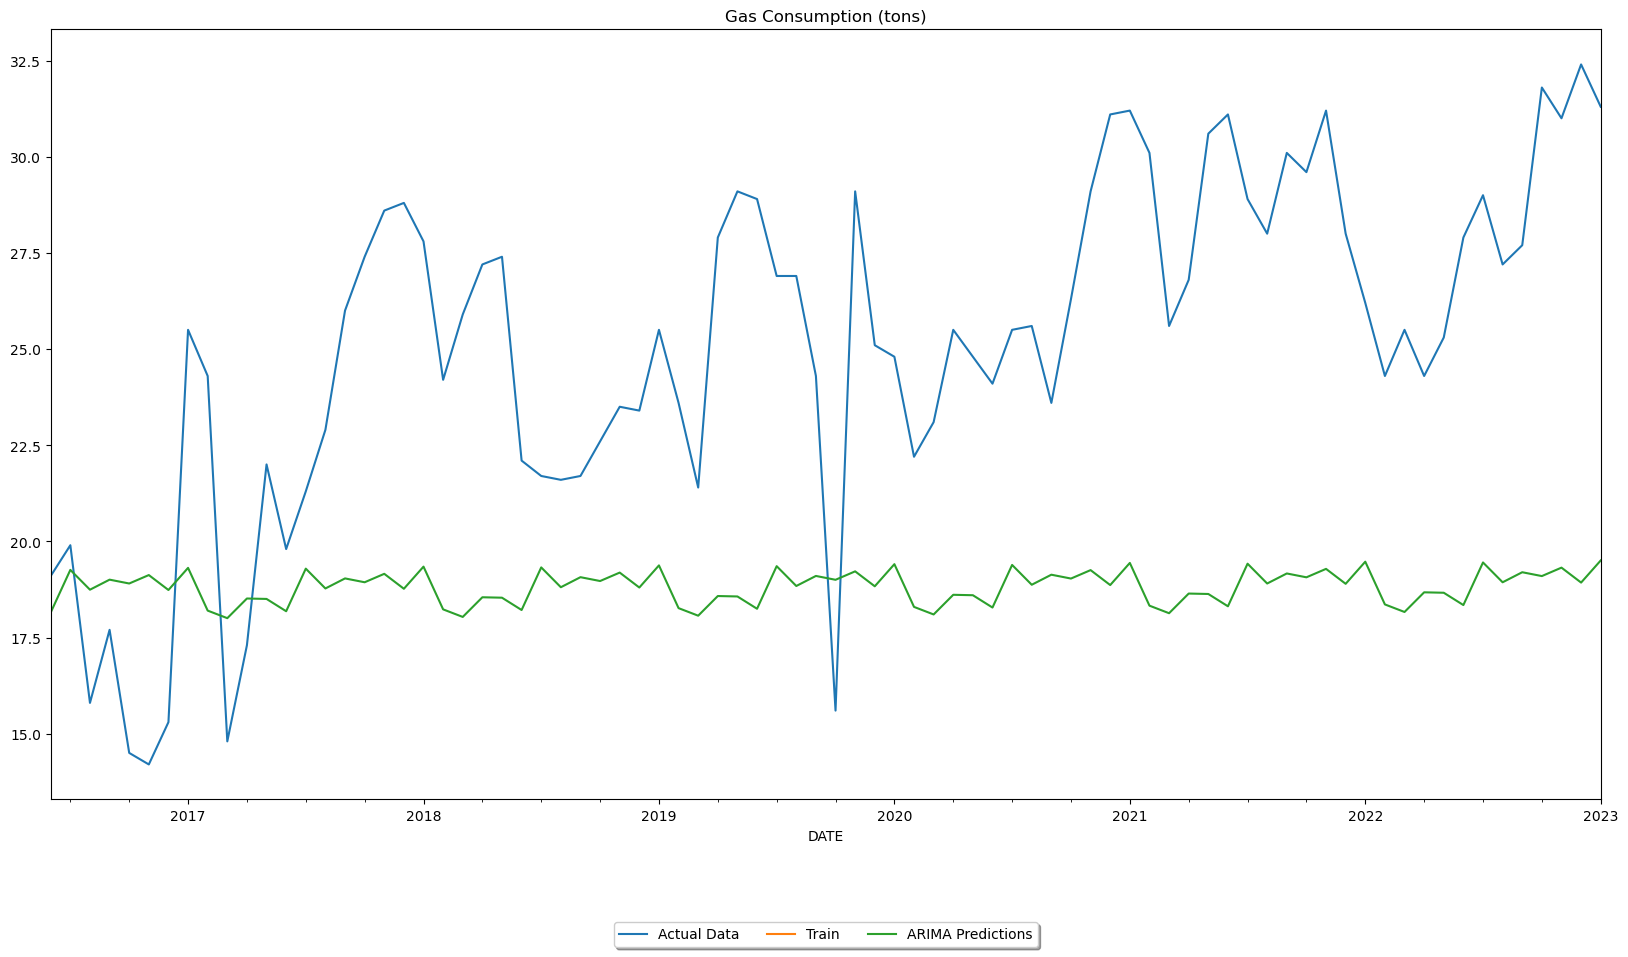

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Water Consumption (tons)')

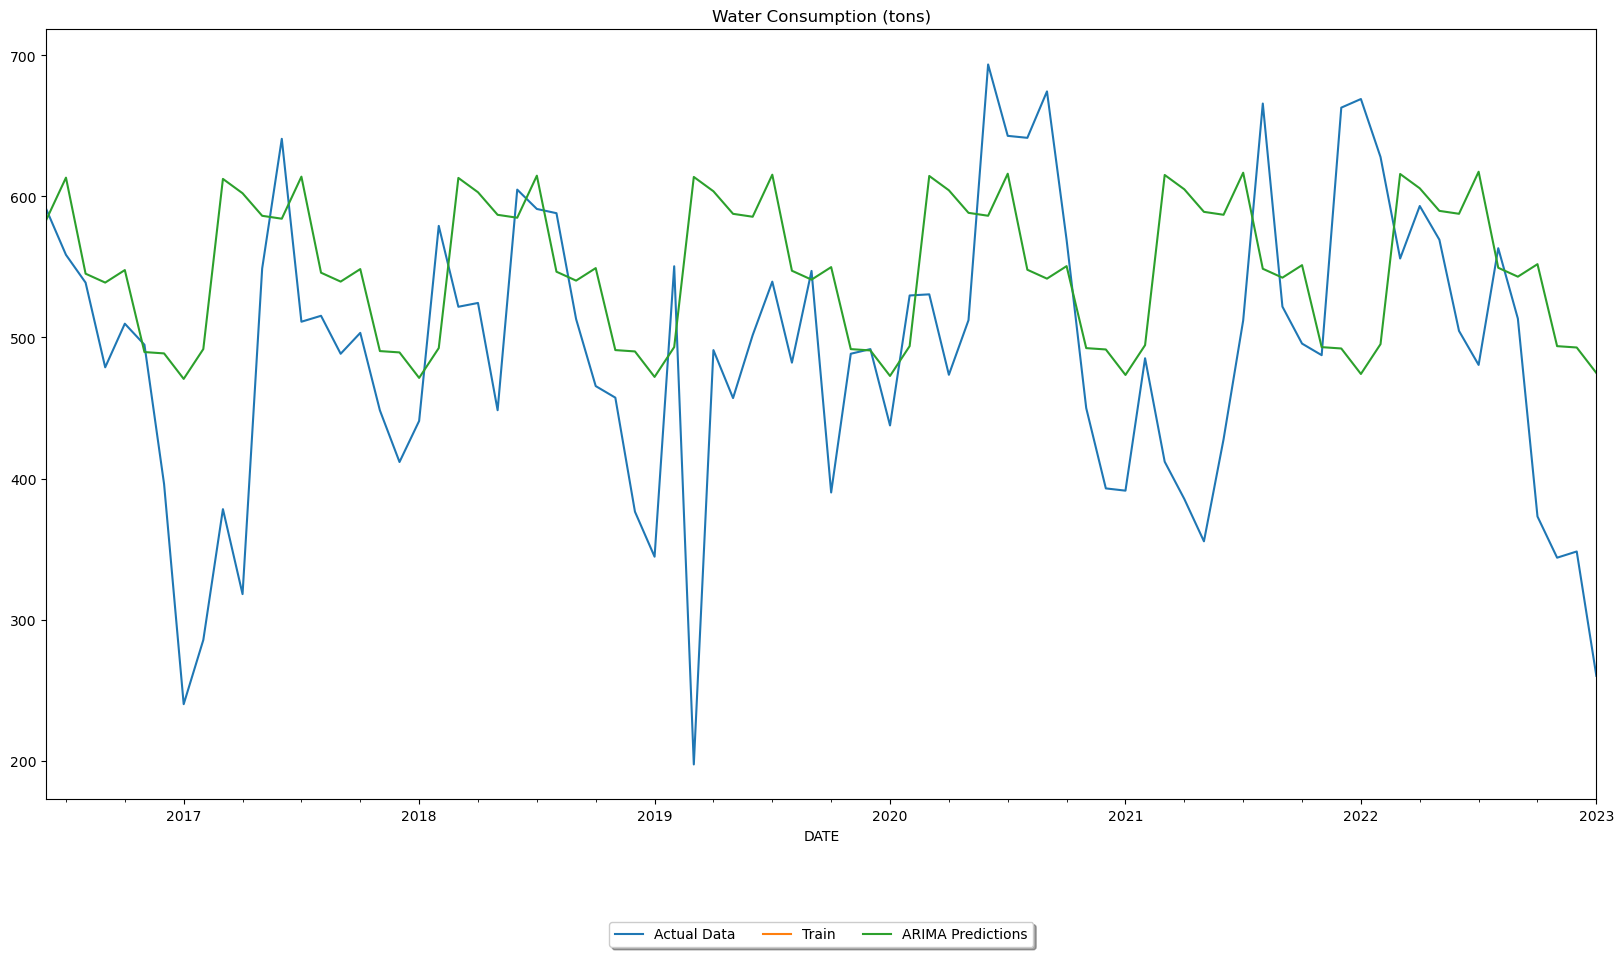

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Electricity Consumption (MWh)')

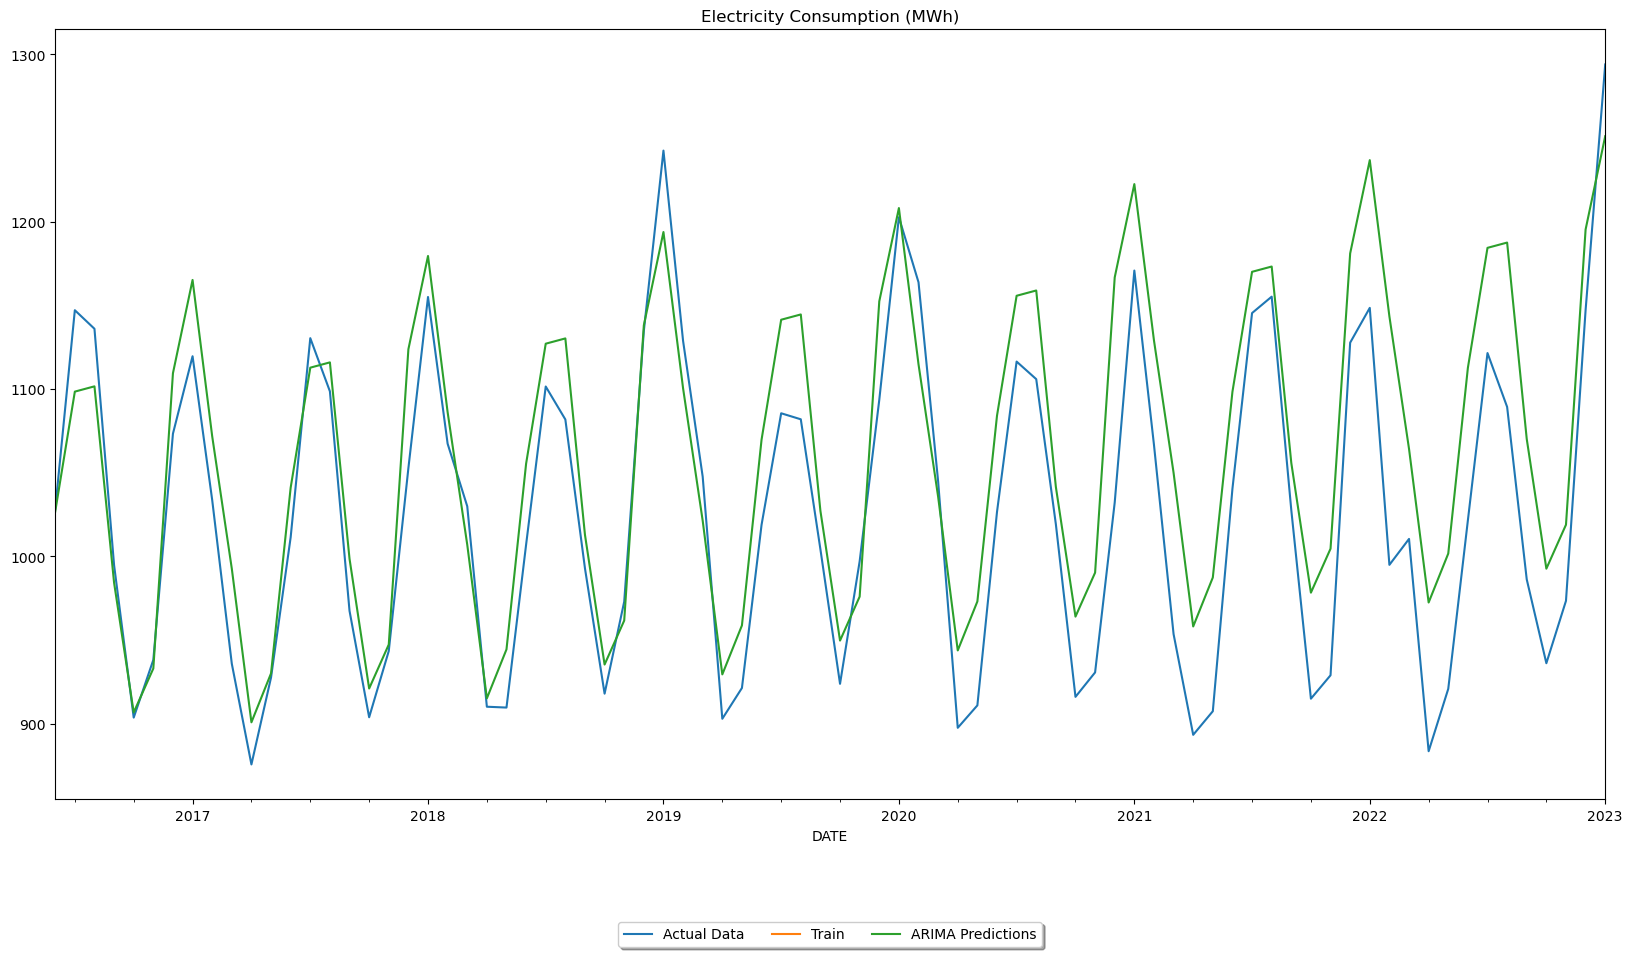

In [35]:


labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']
for i in range(len(labels)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    fullPred = HWmodels[i].predict()
    pred = HWmodels[i].forecast(df_test.shape[0])
    df_test[labels[i]].plot(ax=ax, label="Actual Data")
    fullPred.plot(ax=ax, label="Train")
    pred.plot(ax=ax, label="ARIMA Predictions")
    plt.title(labels[i])
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
    )
    plt.show()

## Hyperparameter Tuning
To improve the model's performance, it is essential to determine the optimal order. While we can identify suitable values for p and q by examining autocorrelation and partial autocorrelation plots. However we can improve it by looping through all the possible combinations to find the best values, similar to GridsearchCv in sklearn.
#### Which models will we be tuning?
We will be tuning SARIMA and comapring it to Holt-winters model. As Holt-winters is already optimized for us we dont need to tune it.

### Gas consumption

In [36]:
def hyperparameter_tune_sarima(train_data, order=(1, 0, 1), seasonal_period=12, P_range=range(0, 4), D_range=range(0, 2), Q_range=range(0, 4)):
    results_df = pd.DataFrame(columns=['Seasonal Order', 'AIC', 'BIC', 'RMSE', 'MAPE'])

    for P in P_range:
        for D in D_range:
            for Q in Q_range:
                try:
                    model = SARIMAX(train_data,
                                   order=order,
                                   seasonal_order=(P, D, Q, seasonal_period)
                                  ).fit(disp=False)
                    aic = model.aic
                    bic = model.bic
                    y_pred = model.get_prediction().predicted_mean
                    rmse = mean_squared_error(train_data, y_pred, squared=False)
                    mape = np.mean(np.abs((train_data - y_pred) / train_data)) * 100
                    # Store results in the DataFrame
                    results_df = results_df.append({'Seasonal Order': (P, D, Q, seasonal_period),
                                                    'AIC': aic,
                                                    'BIC': bic,
                                                    'RMSE': rmse,
                                                    'MAPE': mape,
                                                   }, ignore_index=True)
                except:
                    continue

    return results_df

tuned_results_gasConsumption = hyperparameter_tune_sarima(gasConsumption_train,order=(1, 0, 1), seasonal_period=12, P_range=range(0, 6), D_range=range(0, 2), Q_range=range(0, 6))
display(tuned_results_gasConsumption)

Seasonal Order          AIC          BIC      RMSE       MAPE
0   (0, 0, 0, 12)  1742.458499  1753.735204  3.851967  11.699138
1   (0, 0, 1, 12)  1741.465585  1756.501192  3.834753  11.680397
2   (0, 0, 2, 12)  1743.336412  1762.130921  3.834015  11.676696
3   (0, 0, 3, 12)  1744.733138  1767.286549  3.830353  11.750073
4   (0, 0, 4, 12)  1746.304661  1772.616973  3.827820  11.700064
..            ...          ...          ...       ...        ...
67  (5, 1, 1, 12)  1709.106763  1742.589569  5.588728  15.469993
68  (5, 1, 2, 12)  1710.810876  1748.013994  5.587843  15.461005
69  (5, 1, 3, 12)  1702.844215  1743.767645  5.538656  15.389228
70  (5, 1, 4, 12)  1705.383908  1750.027649  5.539199  15.365452
71  (5, 1, 5, 12)  1706.357516  1754.721569  5.536315  15.348481

[72 rows x 5 columns]

### Water Consumption

In [37]:
tuned_results_waterConsumption = hyperparameter_tune_sarima(waterConsumption_train,order=(1, 1, 1), seasonal_period=12, P_range=range(0, 6), D_range=range(0, 2), Q_range=range(0, 6))
display(tuned_results_waterConsumption)

Seasonal Order          AIC          BIC        RMSE       MAPE
0   (0, 0, 0, 12)  3837.961223  3849.228449  108.219140  22.009275
1   (0, 0, 1, 12)  3839.823518  3854.846487  108.196828  22.002377
2   (0, 0, 2, 12)  3834.423004  3853.201715  107.031582  21.716008
3   (0, 0, 3, 12)  3836.401398  3858.935851  107.028941  21.720572
4   (0, 0, 4, 12)  3838.381881  3864.672077  107.025758  21.709892
..            ...          ...          ...         ...        ...
67  (5, 1, 1, 12)  3735.783264  3769.236514  113.321535  23.121432
68  (5, 1, 2, 12)  3741.295070  3778.465347  113.925215  23.388573
69  (5, 1, 3, 12)  3736.264363  3777.151668  112.791522  23.169978
70  (5, 1, 4, 12)  3740.617309  3785.221642  112.900597  23.068468
71  (5, 1, 5, 12)  3754.363275  3802.684635  114.884090  23.431404

[72 rows x 5 columns]

### Electricity Consumption

In [38]:
tuned_results_electricityConsumption = hyperparameter_tune_sarima(electricityConsumption_train,order=(1, 1, 1), seasonal_period=12, P_range=range(0, 6), D_range=range(0, 2), Q_range=range(0, 6))
display(tuned_results_electricityConsumption)

Seasonal Order          AIC          BIC        RMSE        MAPE
0   (0, 0, 0, 12)  3506.577563  3517.844790   73.703209    6.102317
1   (0, 0, 1, 12)  3329.939225  3344.962194   61.516201    4.541478
2   (0, 0, 2, 12)  3219.928125  3238.706836   56.146574    3.786647
3   (0, 0, 3, 12)  3157.389818  3179.924271   53.757647    3.505653
4   (0, 0, 4, 12)  3887.864350  3914.154545  110.374563    8.860091
5   (0, 0, 5, 12)  3108.644400  3138.690338   51.879095    3.134667
6   (0, 1, 0, 12)  2862.366016  2873.517100   52.280320    2.871146
7   (0, 1, 1, 12)  2758.017316  2772.885427   50.283882    2.534250
8   (0, 1, 2, 12)  2759.942647  2778.527786   50.284068    2.534943
9   (0, 1, 3, 12)  2754.317144  2776.619311   50.154253    2.499671
10  (0, 1, 4, 12)  2754.729382  2780.748576   50.126410    2.494175
11  (0, 1, 5, 12)  2755.658787  2785.395009   50.109013    2.495639
12  (1, 0, 0, 12)  3013.292793  3028.315762   49.496777    2.837656
13  (1, 0, 1, 12)  2966.606870  2985.385581   48.184598    2.543018
14  (1, 0, 2, 12)  2966.218323  2988.752776   48.360491    2.556336
15  (1, 0, 4, 12)  2940.583376  2970.629314   47.733157    2.528847
16  (1, 0, 5, 12)  2963.491140  2997.292819   47.841672    2.503957
17  (1, 1, 0, 12)  2813.067777  2827.935888   51.245906    2.688522
18  (1, 1, 1, 12)  2759.969069  2778.554208   50.284022    2.534694
19  (1, 1, 2, 12)  2760.307615  2782.609781   50.260213    2.532651
20  (1, 1, 3, 12)  2753.416986  2779.436180   50.096992    2.493766
21  (1, 1, 4, 12)  2752.397219  2782.133441   50.045464    2.476107
22  (1, 1, 5, 12)  2758.728781  2792.182030   50.126394    2.493927
23  (2, 0, 0, 12)  2978.543709  2997.322420   48.543815    2.682291
24  (2, 0, 1, 12)  3017.754643  3040.289096   49.483758    2.830816
25  (2, 0, 3, 12)    16.000000    46.045938  865.791013  100.000000
26  (2, 0, 4, 12)  3018.137481  3051.939161   49.360730    2.714807
27  (2, 1, 0, 12)  2774.368943  2792.954081   50.521444    2.558212
28  (2, 1, 1, 12)  2755.746841  2778.049007   50.180900    2.508307
29  (2, 1, 2, 12)  2753.211357  2779.230551   50.088432    2.484600
30  (2, 1, 3, 12)  2753.344736  2783.080957   50.060869    2.481954
31  (2, 1, 4, 12)  2756.432643  2789.885892   50.080494    2.485652
32  (2, 1, 5, 12)  2759.440256  2796.610533   50.104149    2.491492
33  (3, 0, 2, 12)    16.000000    46.045938  642.603632   60.438144
34  (3, 0, 5, 12)    22.000000    63.313164  865.791013  100.000000
35  (3, 1, 0, 12)  2763.256644  2785.558810   50.303245    2.514954
36  (3, 1, 1, 12)  2757.316876  2783.336070   50.173276    2.505641
37  (3, 1, 2, 12)  2759.611980  2789.348201   50.178383    2.505956
38  (3, 1, 3, 12)  2757.262507  2790.715756   50.084901    2.488839
39  (3, 1, 4, 12)  2756.105177  2793.275454   50.033528    2.470444
40  (3, 1, 5, 12)  2761.336648  2802.223953   50.080339    2.506095
41  (4, 0, 1, 12)  2987.120332  3017.166269   47.969117    2.513461
42  (4, 1, 0, 12)  2759.104836  2785.124030   50.202584    2.503940
43  (4, 1, 1, 12)  2758.679451  2788.415673   50.162885    2.506622
44  (4, 1, 2, 12)  2756.967998  2790.421248   50.091754    2.486578
45  (4, 1, 3, 12)  2756.514762  2793.685039   50.042863    2.472890
46  (4, 1, 4, 12)  2758.794665  2799.681969   50.050861    2.471715
47  (4, 1, 5, 12)  2760.303857  2804.908189   50.036793    2.470370
48  (5, 1, 0, 12)  2759.144112  2788.880333   50.170080    2.501754
49  (5, 1, 1, 12)  2761.874359  2795.327608   50.181746    2.496002
50  (5, 1, 2, 12)  2762.347158  2799.517435   50.157259    2.502909
51  (5, 1, 3, 12)  2758.466470  2799.353775   50.045019    2.474153
52  (5, 1, 4, 12)  2760.426864  2805.031196   50.046521    2.468702
53  (5, 1, 5, 12)  2768.563862  2816.885222   50.101173    2.483025

Observations
- We can see that some of the seasonal orders give very low AIC and BIC, and very high RSME and MAPE values.
    - This could be due to alot of factors, Data mismatch etc..

In [39]:
results_list =[tuned_results_gasConsumption,tuned_results_waterConsumption,tuned_results_electricityConsumption]
labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']
for i, df in enumerate(results_list):
    if i == 2:
        df['Combined Score'] = df['AIC'][(df['AIC'] > 2000)] + df['BIC'][df['BIC'] > 2000] + df['RMSE'] + df['MAPE']
    else:
        df['Combined Score'] = df['AIC'] + df['BIC'] + df['RMSE'] + df['MAPE']
    best_combined_idx = df['Combined Score'].idxmin()
    best_combined_order = df.loc[best_combined_idx, 'Seasonal Order']
    
    print(f"Overall Best Seasonal Order (Combined Score) for {labels[i]}:", best_combined_order, "\n")
    print("AIC", df.loc[best_combined_idx, 'AIC'])
    print("BIC", df.loc[best_combined_idx, 'BIC'])
    print("RMSE", df.loc[best_combined_idx, 'RMSE'])
    print("MAPE", df.loc[best_combined_idx, 'MAPE'])
    print("Combined Score", df.loc[best_combined_idx, 'Combined Score'])
    print("\n")


Overall Best Seasonal Order (Combined Score) for Gas Consumption (tons): (0, 1, 1, 12) 

AIC 1704.9759586418106
BIC 1719.8572057482402
RMSE 5.611473344482238
MAPE 15.669071403796023
Combined Score 3446.1137091383293


Overall Best Seasonal Order (Combined Score) for Water Consumption (tons): (0, 1, 1, 12) 

AIC 3729.7793211578937
BIC 3744.6474319635186
RMSE 114.21815952763973
MAPE 23.256055214080124
Combined Score 7611.900967863132


Overall Best Seasonal Order (Combined Score) for Electricity Consumption (MWh): (0, 1, 3, 12) 

AIC 2754.317144392312
BIC 2776.6193106007495
RMSE 50.154253313957504
MAPE 2.499670736741597
Combined Score 5583.590379043761




| Time Series | Best Seasonal Order |
|-----------------|-----------------|
| Gas Consumption| (0, 1, 1, 12) |
| Water Consumption| (0, 1, 1, 12) |
| Electricity Consumption| (0, 1, 3, 12) |

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Gas Consumption (tons)')

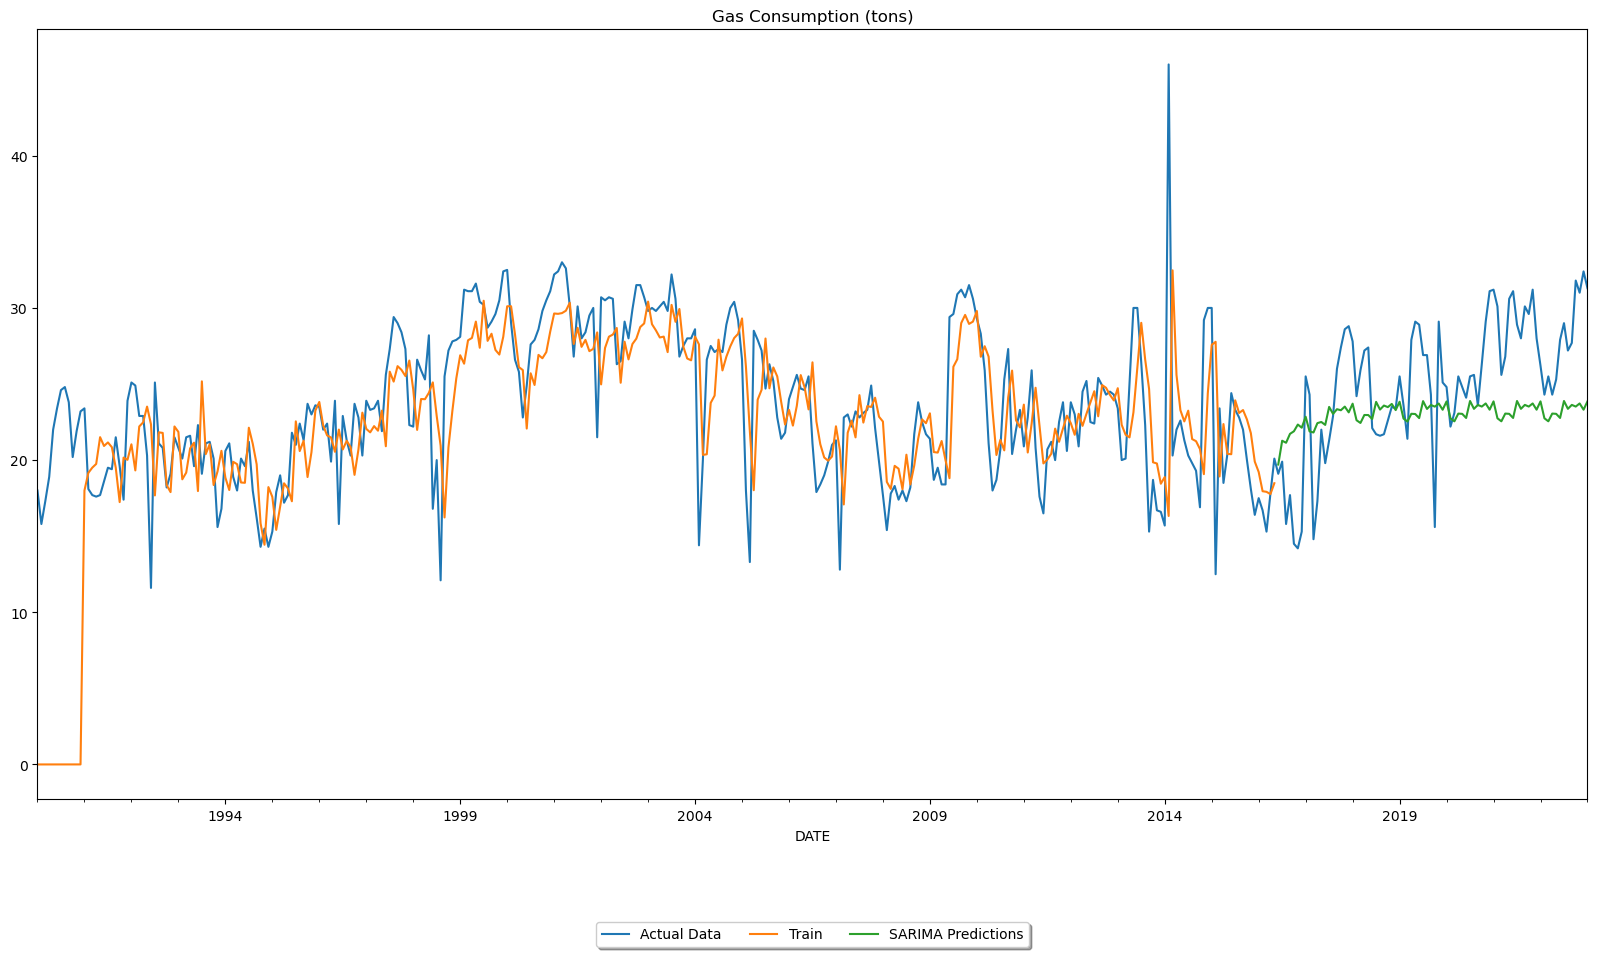

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Water Consumption (tons)')

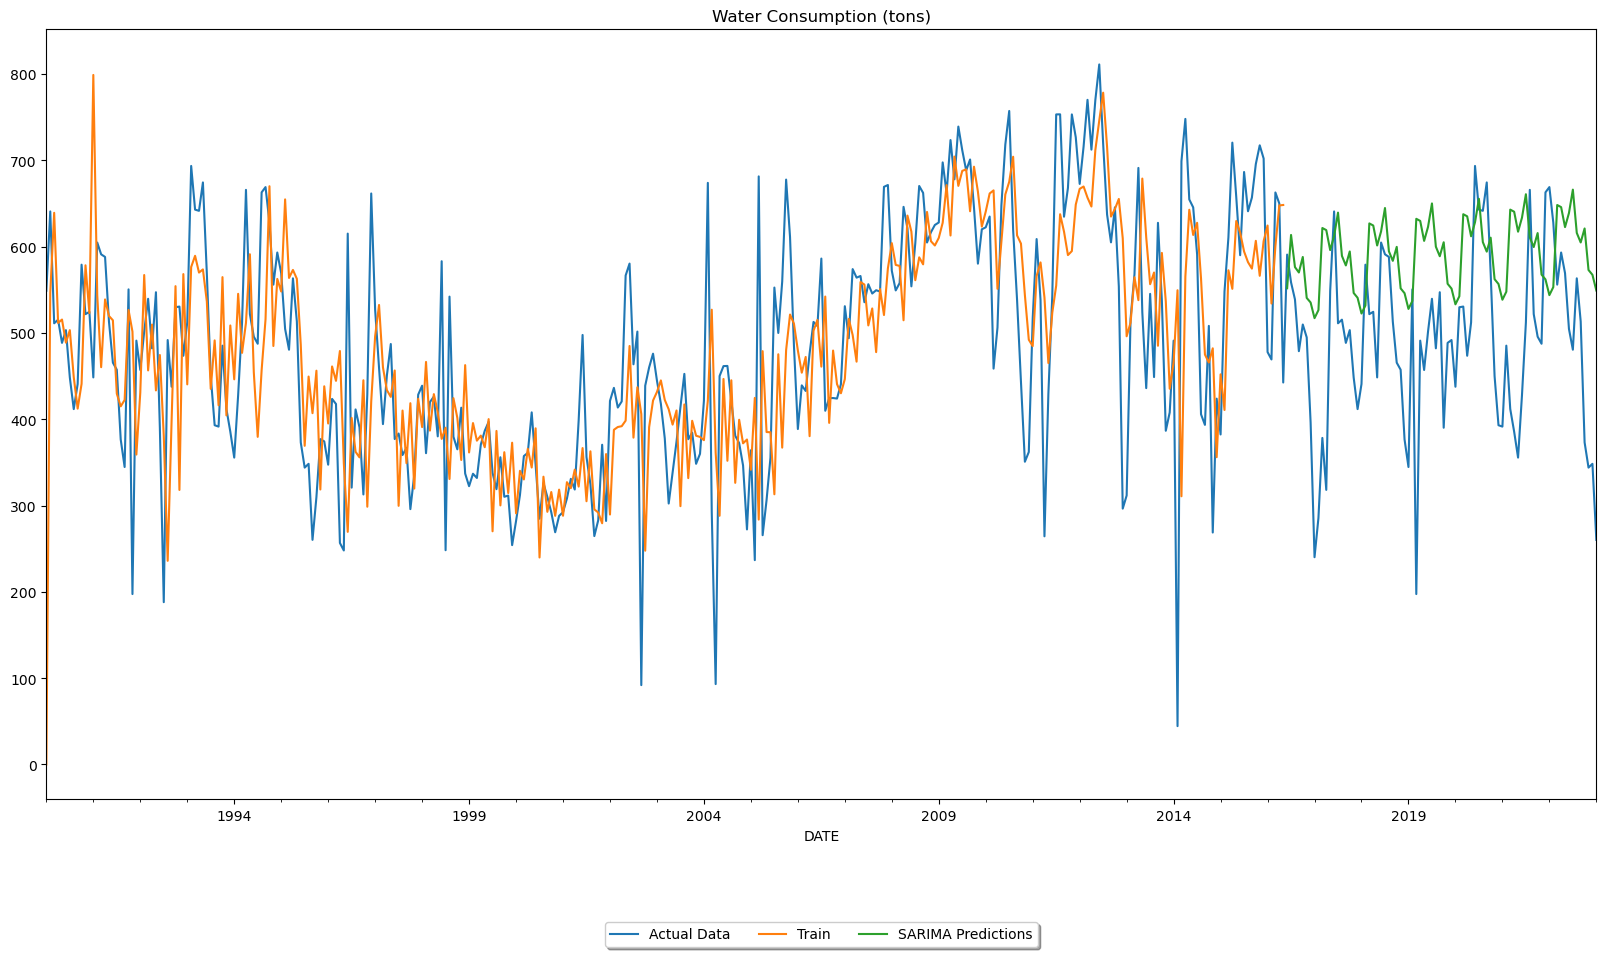

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Electricity Consumption (MWh)')

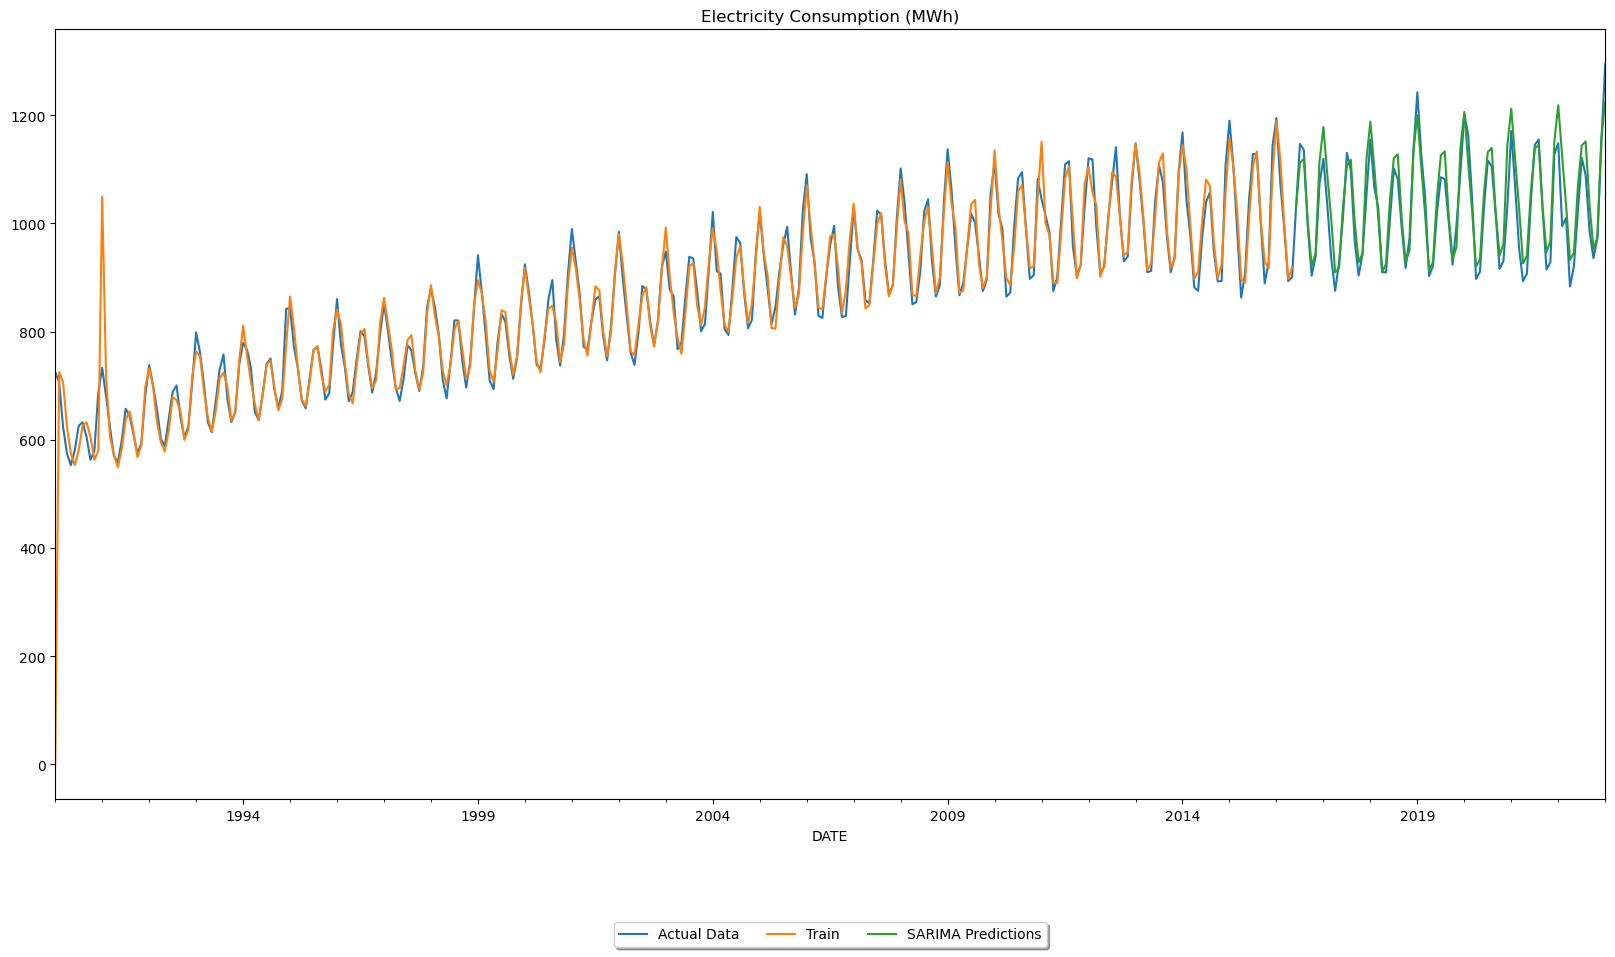

In [40]:
df = df_raw.copy()
df.index = df['DATE'] 
df.drop(columns= 'DATE', inplace = True) 

SARIMAmodels = [
    SARIMAX(gasConsumption_train, order=(1, 0, 1),seasonal_order=(0,1,1,12)).fit(),
    SARIMAX(waterConsumption_train, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit(),
    SARIMAX(electricityConsumption_train, order=(1, 1, 1),seasonal_order=(0,1,3,12)).fit()
]


labels = ['Gas Consumption (tons)', 'Water Consumption (tons)', 'Electricity Consumption (MWh)']
for i in range(len(labels)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    fullPred = SARIMAmodels[i].predict()
    pred = SARIMAmodels[i].forecast(df_test.shape[0])
    df[labels[i]].plot(ax=ax, label="Actual Data")
    fullPred.plot(ax=ax, label="Train")
    pred.plot(ax=ax, label="SARIMA Predictions")
    plt.title(labels[i])
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
    )
    plt.show()

### Comaparison of SARIMA with Holts-Winters

In [41]:
SARIMAmodels = [
    SARIMAX(gasConsumption_train, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12)).fit(),
    SARIMAX(waterConsumption_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(),
    SARIMAX(electricityConsumption_train, order=(1, 1, 1), seasonal_order=(0, 1, 3, 12)).fit()
]

HWmodels = [
    ExponentialSmoothing(gasConsumption_train, trend="add", seasonal="add", seasonal_periods=12).fit(),
    ExponentialSmoothing(waterConsumption_train, trend="add", seasonal="add", seasonal_periods=12).fit(),
    ExponentialSmoothing(electricityConsumption_train, trend="add", seasonal="add", seasonal_periods=12).fit()
]

results_df_SARIMA = pd.DataFrame(columns=['Category', 'Model', 'AIC', 'BIC', 'RMSE', 'MAPE'])
results_df_HW = pd.DataFrame(columns=['Category', 'Model', 'AIC', 'BIC', 'RMSE', 'MAPE'])

for i, category in enumerate(labels):
    sarima_model = SARIMAmodels[i]
    hw_model = HWmodels[i]

    sarima_y_pred = sarima_model.forecast(steps=len(df_test))
    sarima_rmse = np.sqrt(mean_squared_error(df_test[labels[i]], sarima_y_pred))
    sarima_mape = calculate_mape(df_test[labels[i]], sarima_y_pred)

    hw_y_pred = hw_model.forecast(steps=len(df_test))
    hw_rmse = np.sqrt(mean_squared_error(df_test[labels[i]], hw_y_pred))
    hw_mape = calculate_mape(df_test[labels[i]], hw_y_pred)

    results_df_SARIMA = results_df_SARIMA.append({'Category': category,
                                    'Model': 'SARIMA',
                                    'AIC': sarima_model.aic,
                                    'BIC': sarima_model.bic,
                                    'RMSE': sarima_rmse,
                                    'MAPE': sarima_mape
                                   }, ignore_index=True)

    results_df_HW = results_df_HW.append({'Category': category,
                                    'Model': 'Holt-Winters',
                                    'AIC': hw_model.aic,
                                    'BIC': hw_model.bic,
                                    'RMSE': hw_rmse,
                                    'MAPE': hw_mape
                                   }, ignore_index=True)

display(results_df_SARIMA)
display(results_df_HW)

Category   Model          AIC          BIC  \
0         Gas Consumption (tons)  SARIMA  1704.975959  1719.857206   
1       Water Consumption (tons)  SARIMA  3729.779321  3744.647432   
2  Electricity Consumption (MWh)  SARIMA  2754.317144  2776.619311   

         RMSE       MAPE  
0    4.530745  15.426113  
1  143.304738  29.822465  
2   38.767599   2.985868

Category         Model          AIC          BIC  \
0         Gas Consumption (tons)  Holt-Winters   859.595561   919.737990   
1       Water Consumption (tons)  Holt-Winters  3007.009845  3067.152273   
2  Electricity Consumption (MWh)  Holt-Winters  2020.673541  2080.815970   

         RMSE       MAPE  
0    7.643291  26.349302  
1  118.947117  22.934147  
2   52.460154   4.295020

Observations
- As our main focus is to predict the future consumption of gas, water and electricity. RMSE and MAPE will be taken more into consideration when choosing the models
- For water consumption, Holt-winters performs better in both the fit of the model and predictions
- While Holt-winters has a better fit for all the time series, we will be using SARIMA for Gas consumption and electricity consumption as it has better RSME and MAPE values

## Model Selection

| Time Series | Selected Model |
|-----------------|-----------------|
| Gas Consumption| SARIMA |
| Water Consumption| Holt-Winters |
| Electricity Consumption| SARIMA |

## Predictions beyond our dataset
Previously we have been training our model on only 80% of the data and testing to the other 20%. Now we will be training the model on 100% of the data to use the model to forecast into the future.

In [51]:
from IPython.core.interactiveshell import InteractiveShell

gasConsumption = df_new['Gas Consumption (tons)']
waterConsumption = df_new['Water Consumption (tons)']
electricityConsumption = df_new['Electricity Consumption (MWh)']

selectedModels  = [  
    SARIMAX(gasConsumption, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12)).fit(),
    ExponentialSmoothing(waterConsumption, trend="add", seasonal="add", seasonal_periods=12).fit(),
    SARIMAX(electricityConsumption, order=(1, 1, 1), seasonal_order=(0, 1, 3, 12)).fit()

]

for i in range(len(selectedModels)):
    print(selectedModels[i].summary())

InteractiveShell.ast_node_interactivity = "all"

                                     SARIMAX Results                                      
Dep. Variable:             Gas Consumption (tons)   No. Observations:                  397
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1051.220
Date:                            Thu, 10 Aug 2023   AIC                           2110.440
Time:                                    23:49:49   BIC                           2126.253
Sample:                                01-01-1990   HQIC                          2116.712
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8637      0.046     18.602      0.000       0.773       0.955
ma.L1         -0.3531      0.043   

<Axes: >

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Gas Consumption (tons)')

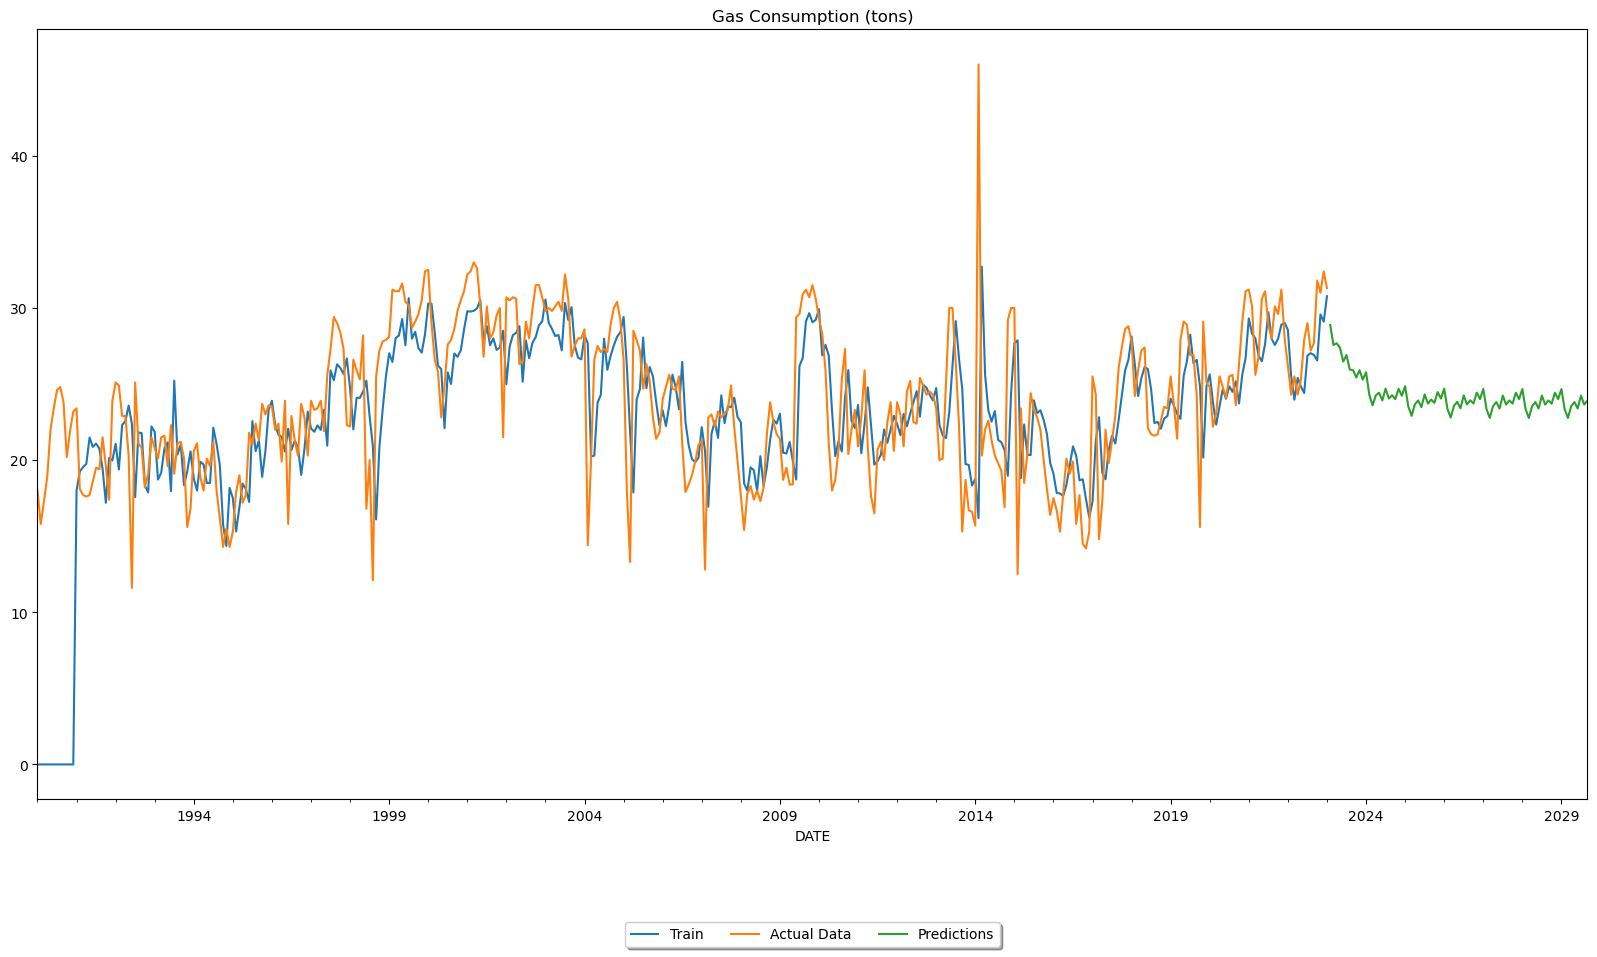

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Water Consumption (tons)')

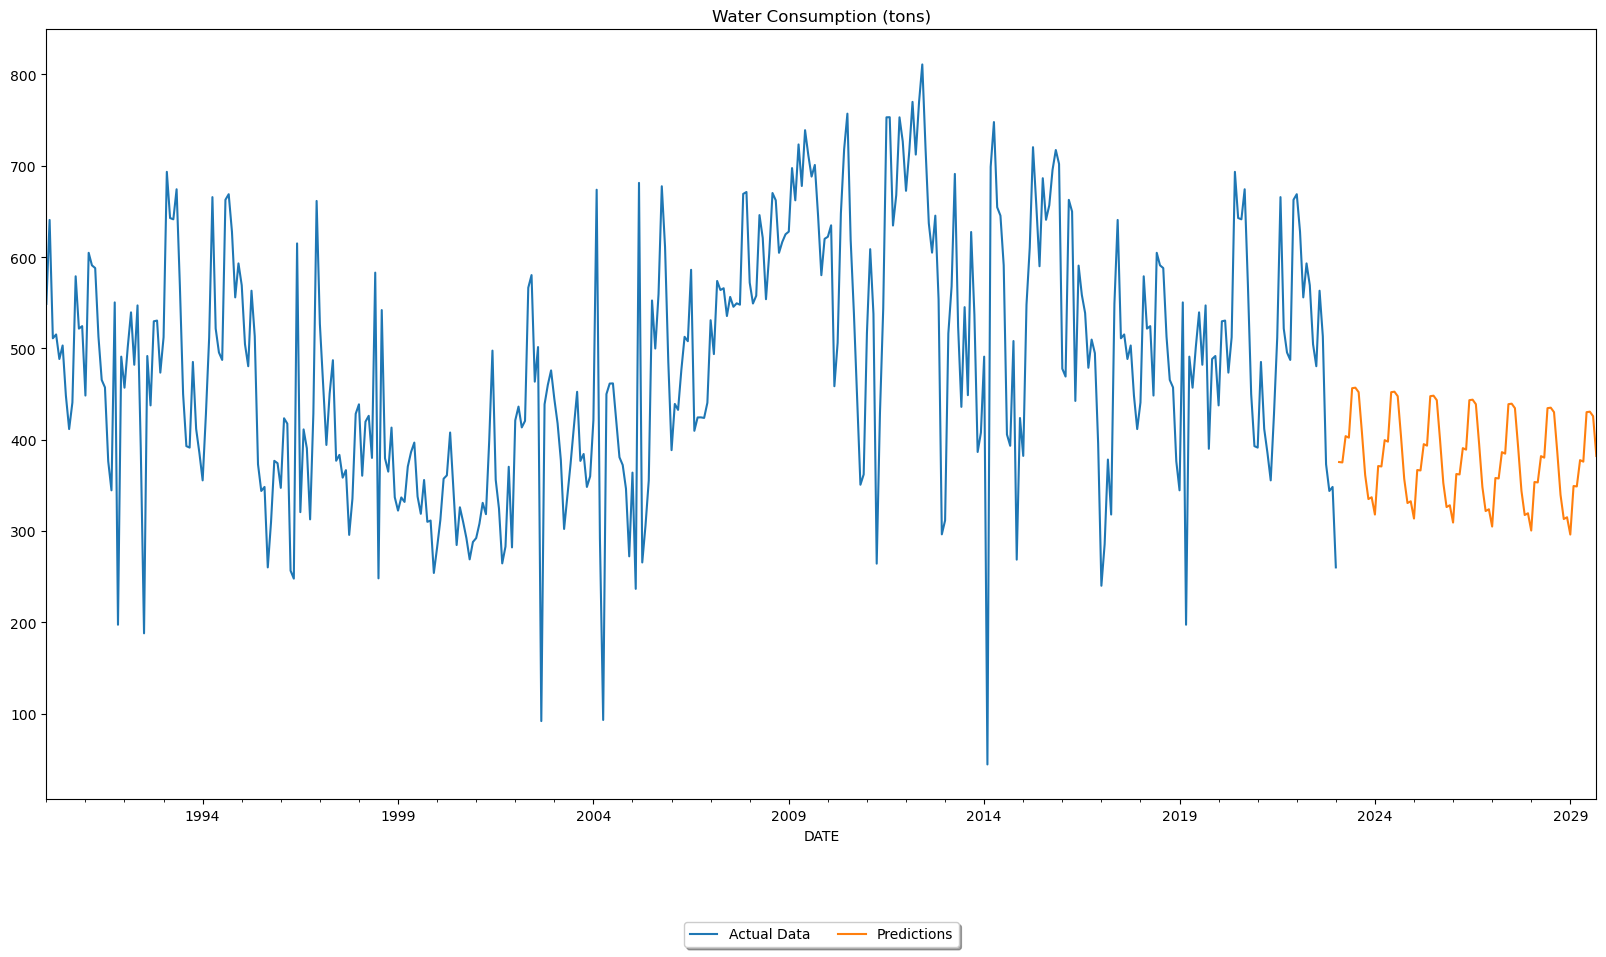

<Axes: >

<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

Text(0.5, 1.0, 'Electricity Consumption (MWh)')

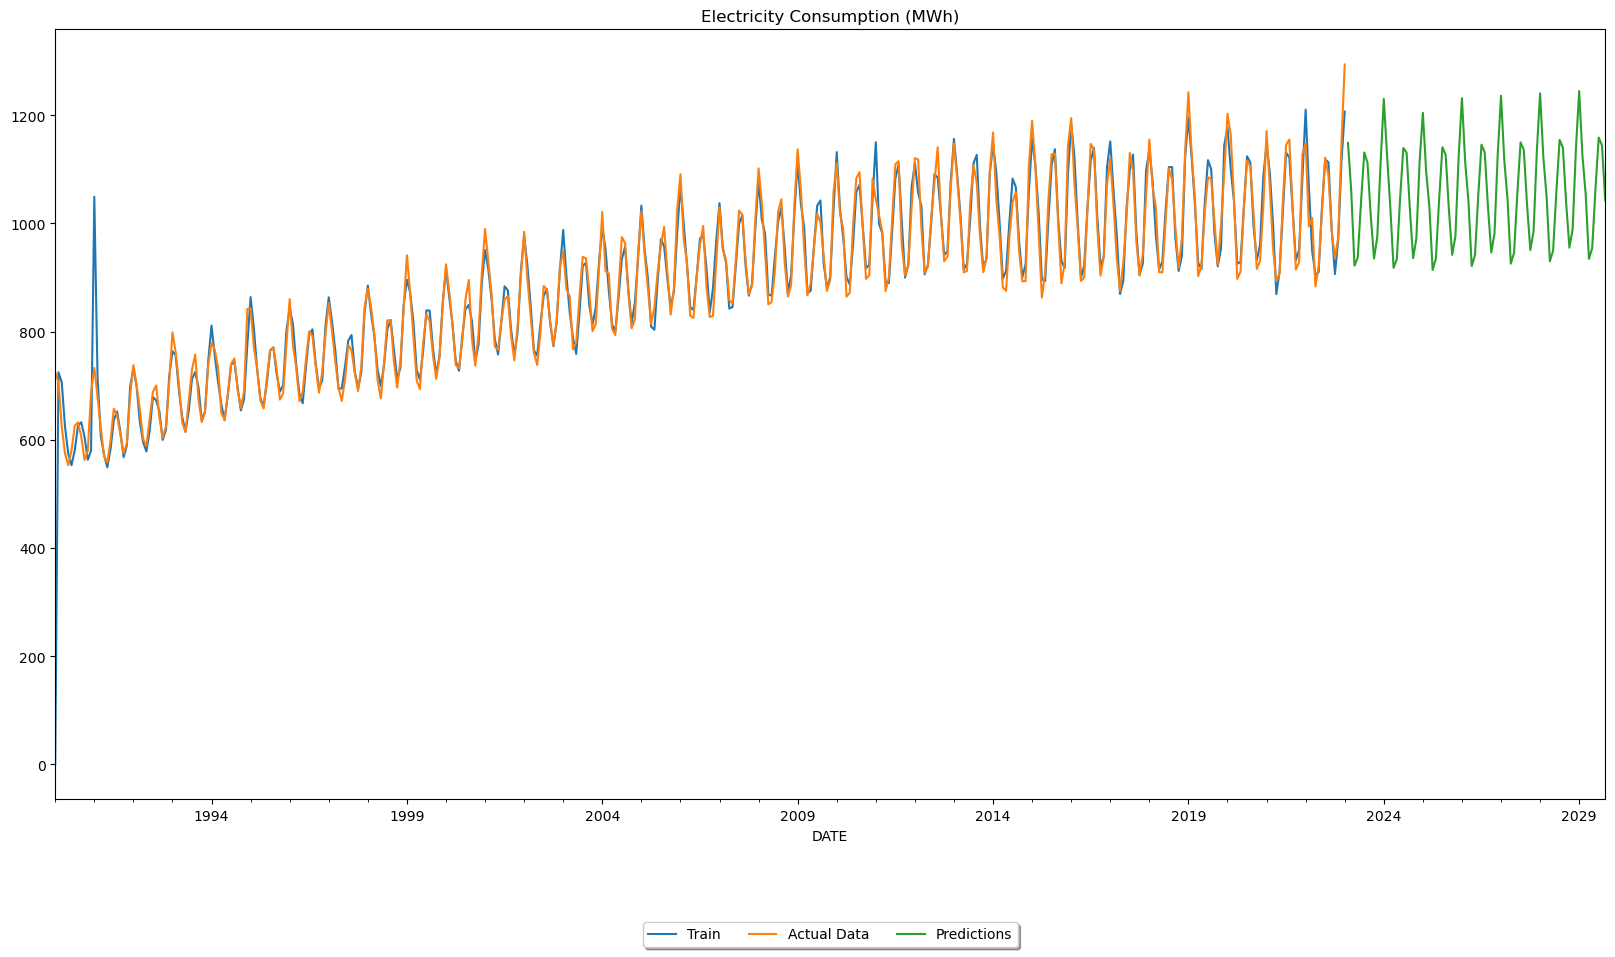

In [53]:
for i in range(len(labels)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    if i != 1:
        fullPred = selectedModels[i].predict()
        fullPred.plot(ax=ax, label="Train")
    pred = selectedModels[i].forecast(df_test.shape[0])
    df[labels[i]].plot(ax=ax, label="Actual Data")
    pred.plot(ax=ax, label="Predictions")
    plt.title(labels[i])
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
    )
    plt.show()

## Conclusion

In this time series analysis project, we aimed to predict and forecast the consumption patterns of gas, water, and electricity over a specific time period. We explored the use of SARIMA, ARIMA and Holt-Winters models to capture and predict the underlying patterns in the data.However, this time series project has its limitations. The chosen models, SARIMA and Holt-Winters, may not capture complex relationships in the data, potentially leading to suboptimal predictions for certain consumption patterns. The performance evaluation metrics used, such as AIC, BIC, RMSE, and MAPE, provide insights into different aspects of model performance but may not encompass all relevant aspects of forecasting accuracy. 

## Reflection
I've learnt alot from this time series project, eventhough it was very long and tedious. The process was enjoyable as i found using data to actually somewhat predict the future very interesting. Its like im using machine learning in a real-world scenario. Even if the example dataset maybe idealistic, its thought me the processes of a time series project.

![](./images/timeseries.png)